In [1]:
import os
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt

# Get all data directories
list_of_commits = list(Path("../../logs/performance/comparison").glob("*/"))
list_of_commits.sort(key=os.path.getmtime, reverse=True)

# Load data from all commits
commit_data = []
for commit_dir in list_of_commits:
    list_of_files = list(Path(commit_dir / "all").glob("*.csv"))
    if list_of_files:
        latest_file = max(list_of_files, key=os.path.getctime)
        df = pd.read_csv(latest_file)
        commit_name = commit_dir.name
        commit_data.append((commit_name, df))
        print(f"Loaded commit: {commit_dir} as {commit_name}")

print(f"Total commits loaded: {len(commit_data)}")

# Filter all dataframes to only include common fainder_modes
if commit_data:
    common_fainder_modes = set(commit_data[0][1]["fainder_mode"].unique())
    for _, df in commit_data[1:]:
        common_fainder_modes &= set(df["fainder_mode"].unique())

    for i in range(len(commit_data)):
        commit_name, df = commit_data[i]
        commit_data[i] = (
            commit_name,
            df[df["fainder_mode"].isin(common_fainder_modes)],
        )


# Function to compare num_results across all commits
def compare_num_results_all(commit_data):
    if len(commit_data) < 2:
        return True

    base_name, base_df = commit_data[0]
    for i in range(len(base_df)):
        test_name = base_df.iloc[i]["test_name"]
        query = base_df.iloc[i]["query"]
        scenario = base_df.iloc[i]["scenario"]
        fainder_mode = base_df.iloc[i]["fainder_mode"]
        base_num_results = base_df.iloc[i]["num_results"]

        for other_name, other_df in commit_data[1:]:
            try:
                other_num_results = other_df[
                    (other_df["test_name"] == test_name)
                    & (other_df["query"] == query)
                    & (other_df["scenario"] == scenario)
                    & (other_df["fainder_mode"] == fainder_mode)
                ]["num_results"].values[0]

                if base_num_results != other_num_results:
                    print(
                        f"num_results mismatch between {base_name} and {other_name}: {test_name}, {query}, {scenario}, {fainder_mode}: {base_num_results} vs {other_num_results}"
                    )
            except IndexError:
                continue
    return True


# compare_num_results_all(commit_data)

for commit_name, df in commit_data:
    print(f"\n{commit_name}:")
    print(df)

Loaded commit: ../../logs/performance/comparison/middle as middle
Loaded commit: ../../logs/performance/comparison/big as big
Loaded commit: ../../logs/performance/comparison/small as small
Total commits loaded: 3

middle:
                timestamp              category  \
0     2025-06-08 11:30:04  base_keyword_queries   
1     2025-06-08 11:30:04  base_keyword_queries   
2     2025-06-08 11:30:04  base_keyword_queries   
3     2025-06-08 11:30:04  base_keyword_queries   
4     2025-06-08 11:30:04  base_keyword_queries   
...                   ...                   ...   
1187  2025-06-08 12:24:28      NOT_Combinations   
1188  2025-06-08 12:24:51      NOT_Combinations   
1189  2025-06-08 12:24:51      NOT_Combinations   
1190  2025-06-08 12:24:51      NOT_Combinations   
1191  2025-06-08 12:24:51      NOT_Combinations   

                            test_name  \
0                    simple_keyword_1   
1                    simple_keyword_1   
2                    simple_keyword_1   


In [2]:
# For each category and scenario create bar plots comparing all commits
import numpy as np

# Create the directory if it doesn't exist
if not os.path.exists("figures"):
    os.makedirs("figures")
if not os.path.exists("figures/regression"):
    os.makedirs("figures/regression")

if not commit_data:
    print("No commit data available")
else:
    scenarios = commit_data[0][1]["scenario"].unique()
    categories = commit_data[0][1]["category"].unique()
    fainder_modes = commit_data[0][1]["fainder_mode"].unique()

    for category in categories:
        for scenario in scenarios:
            plt.figure(figsize=(12, 8))

            # Get data for each commit
            commit_means = {}
            for commit_name, df in commit_data:
                df_temp = df[
                    (df["category"] == category) & (df["scenario"] == scenario)
                ]
                mean_execution_times = df_temp.groupby("fainder_mode")[
                    "execution_time"
                ].mean()
                commit_means[commit_name] = mean_execution_times

            if commit_means:
                x = np.arange(len(fainder_modes))
                width = 0.8 / len(commit_data)

                for i, (commit_name, means) in enumerate(commit_means.items()):
                    values = [means.get(mode, 0) for mode in fainder_modes]
                    plt.bar(x + i * width, values, width, label=commit_name)

                plt.title(f"Execution time for {category} in {scenario}")
                plt.xlabel("Fainder mode")
                plt.ylabel("Execution time (s)")
                plt.xticks(
                    x + width * (len(commit_data) - 1) / 2, fainder_modes, rotation=45
                )
                plt.legend()

                # Save individual figure
                plt.savefig(
                    f"figures/regression/execution_time_{category}_{scenario}.png",
                    bbox_inches="tight",
                )
                plt.close()

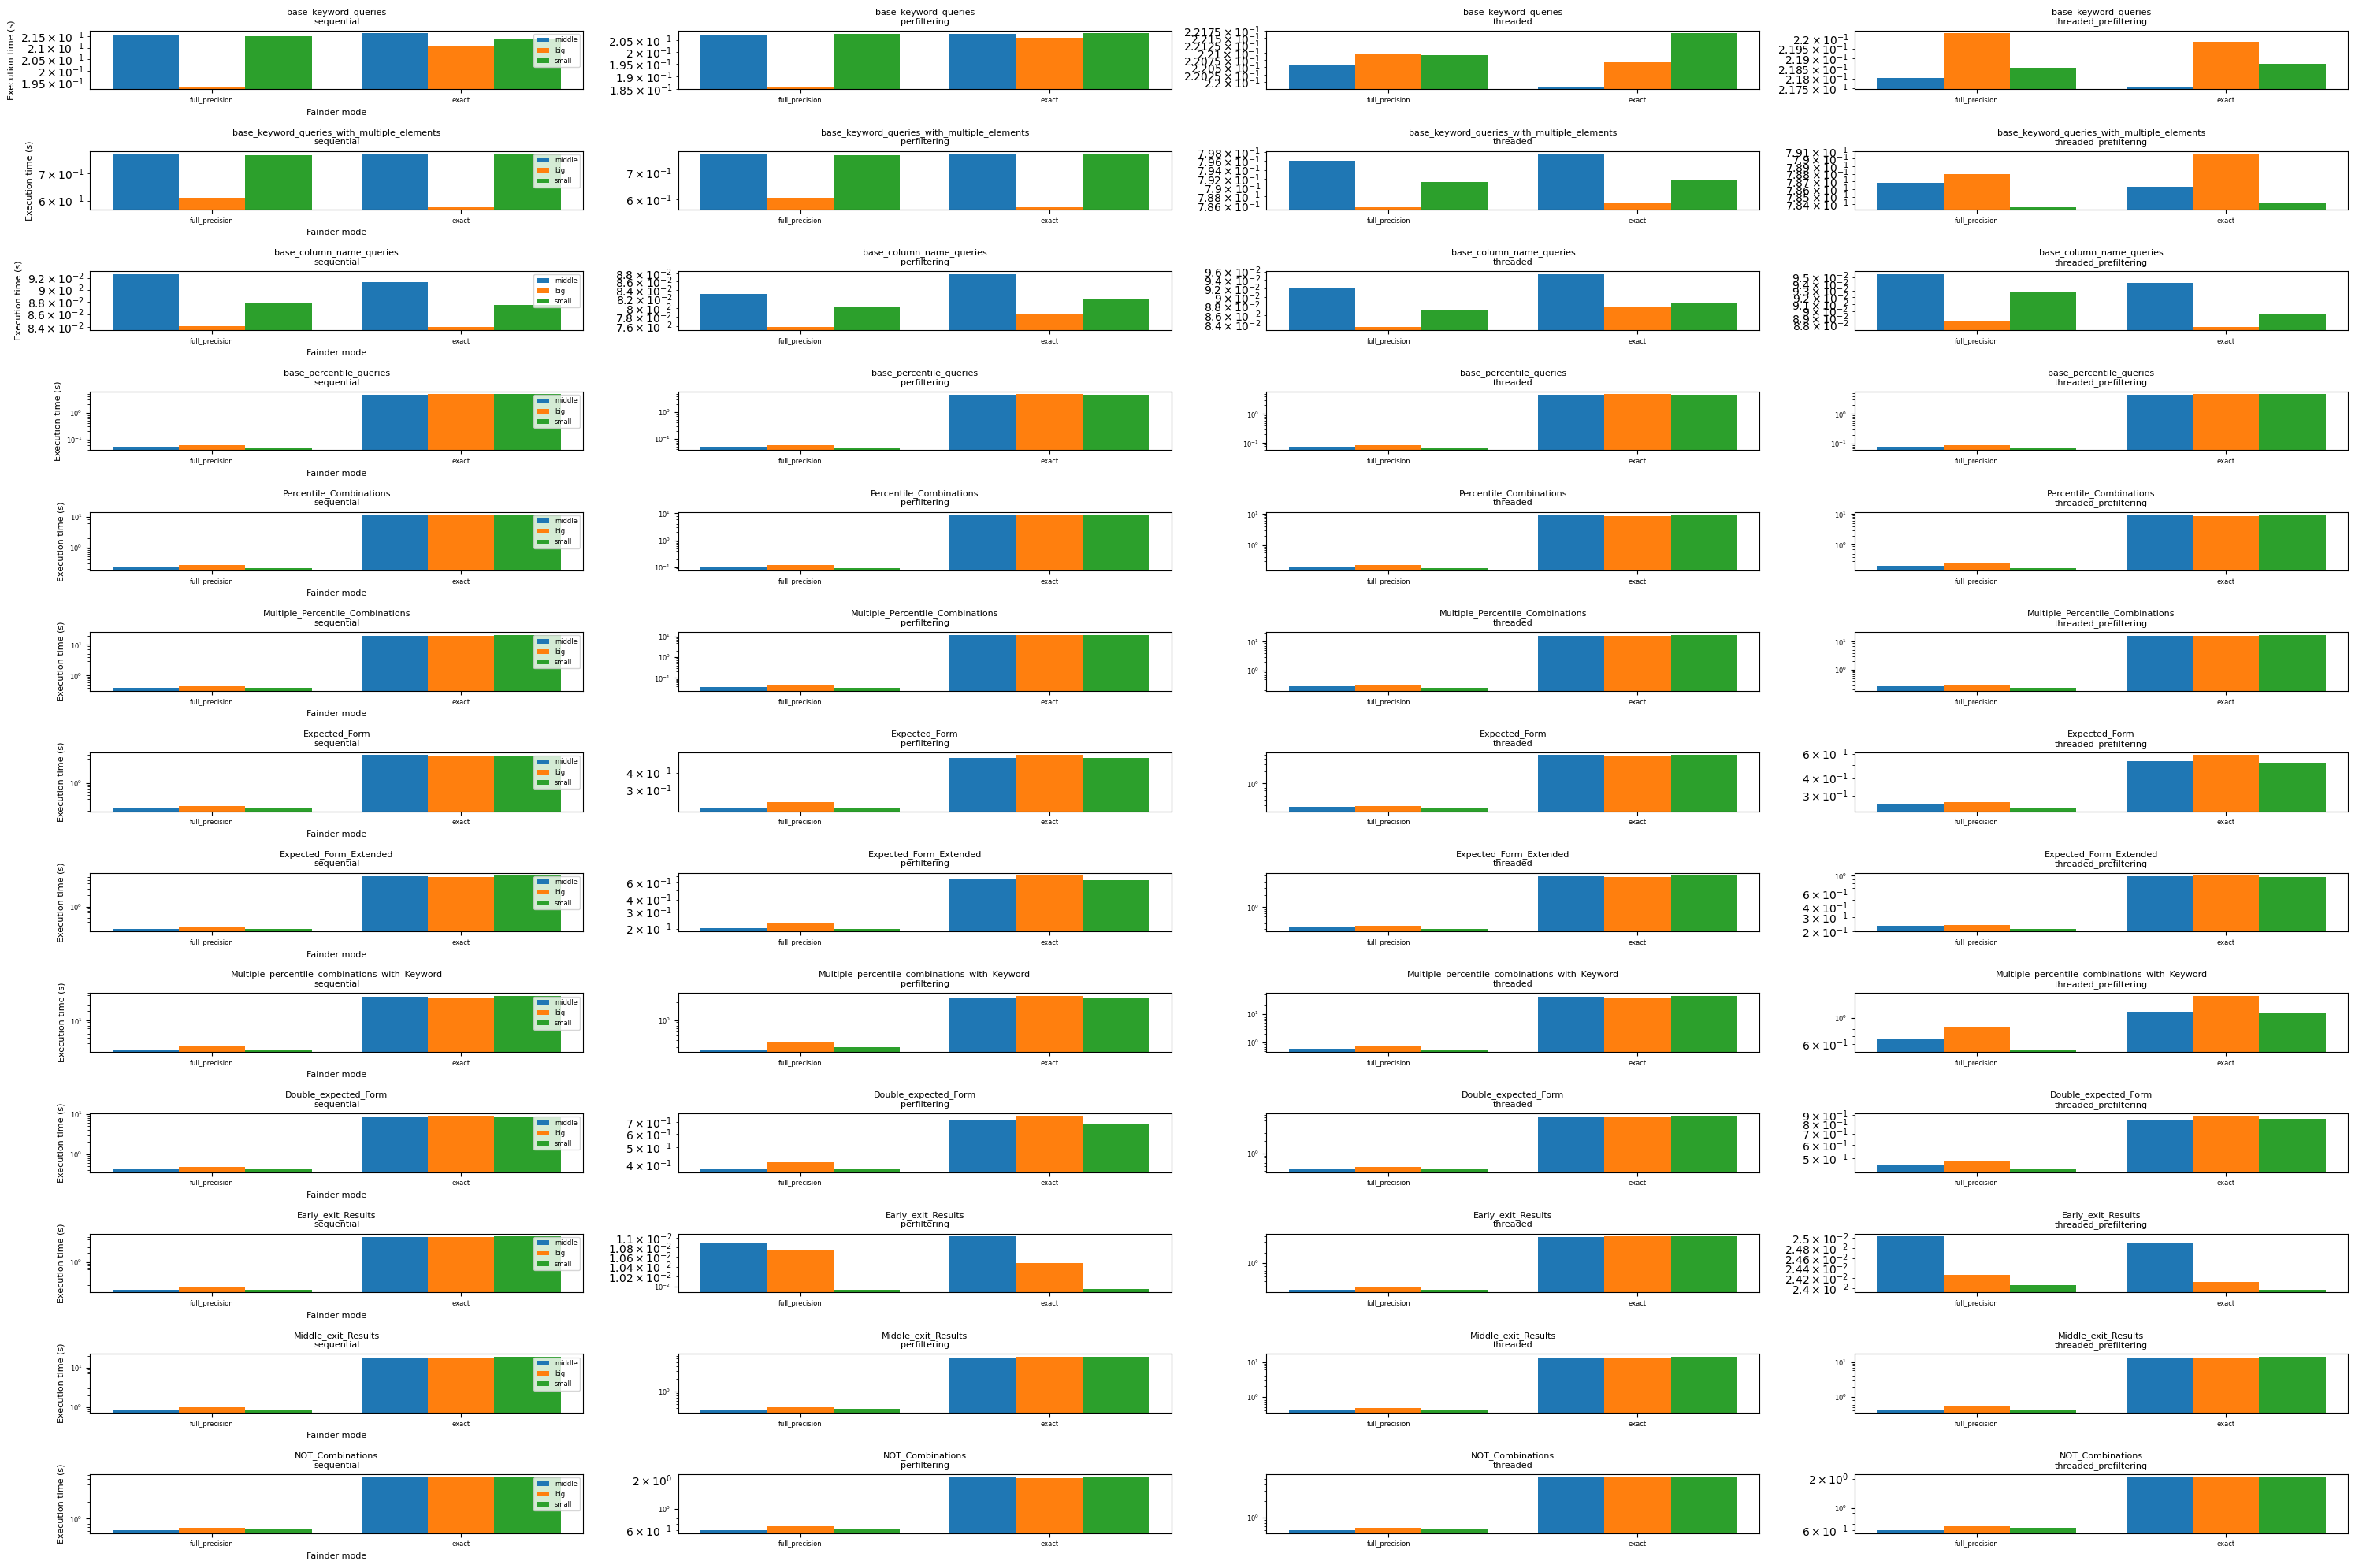

In [3]:
# Create combined figure with log scale
if commit_data:
    plt.figure(figsize=(30, 20))
    num_plots = len(categories) * len(scenarios)
    rows = (num_plots + 3) // 4
    cols = min(4, num_plots)

    for idx, (category, scenario) in enumerate(
        [(c, s) for c in categories for s in scenarios]
    ):
        plt.subplot(rows, cols, idx + 1)

        # Get data for each commit
        commit_means = {}
        for commit_name, df in commit_data:
            df_temp = df[(df["category"] == category) & (df["scenario"] == scenario)]
            mean_execution_times = df_temp.groupby("fainder_mode")[
                "execution_time"
            ].mean()
            commit_means[commit_name] = mean_execution_times

        if commit_means:
            x = np.arange(len(fainder_modes))
            width = 0.8 / len(commit_data)

            for i, (commit_name, means) in enumerate(commit_means.items()):
                values = [means.get(mode, 0) for mode in fainder_modes]
                plt.bar(x + i * width, values, width, label=commit_name)

            plt.yscale("log")

            if idx % 4 == 0:
                plt.legend(loc="upper right", fontsize=6)
                plt.xlabel("Fainder mode", fontsize=8)
                plt.ylabel("Execution time (s)", fontsize=8)
            plt.xticks(
                x + width * (len(commit_data) - 1) / 2, fainder_modes, fontsize=6
            )
            plt.title(f"{category}\n{scenario}", fontsize=8)
            plt.yticks(fontsize=6)

    plt.tight_layout()
    plt.savefig("figures/regression/all_execution_times.png")

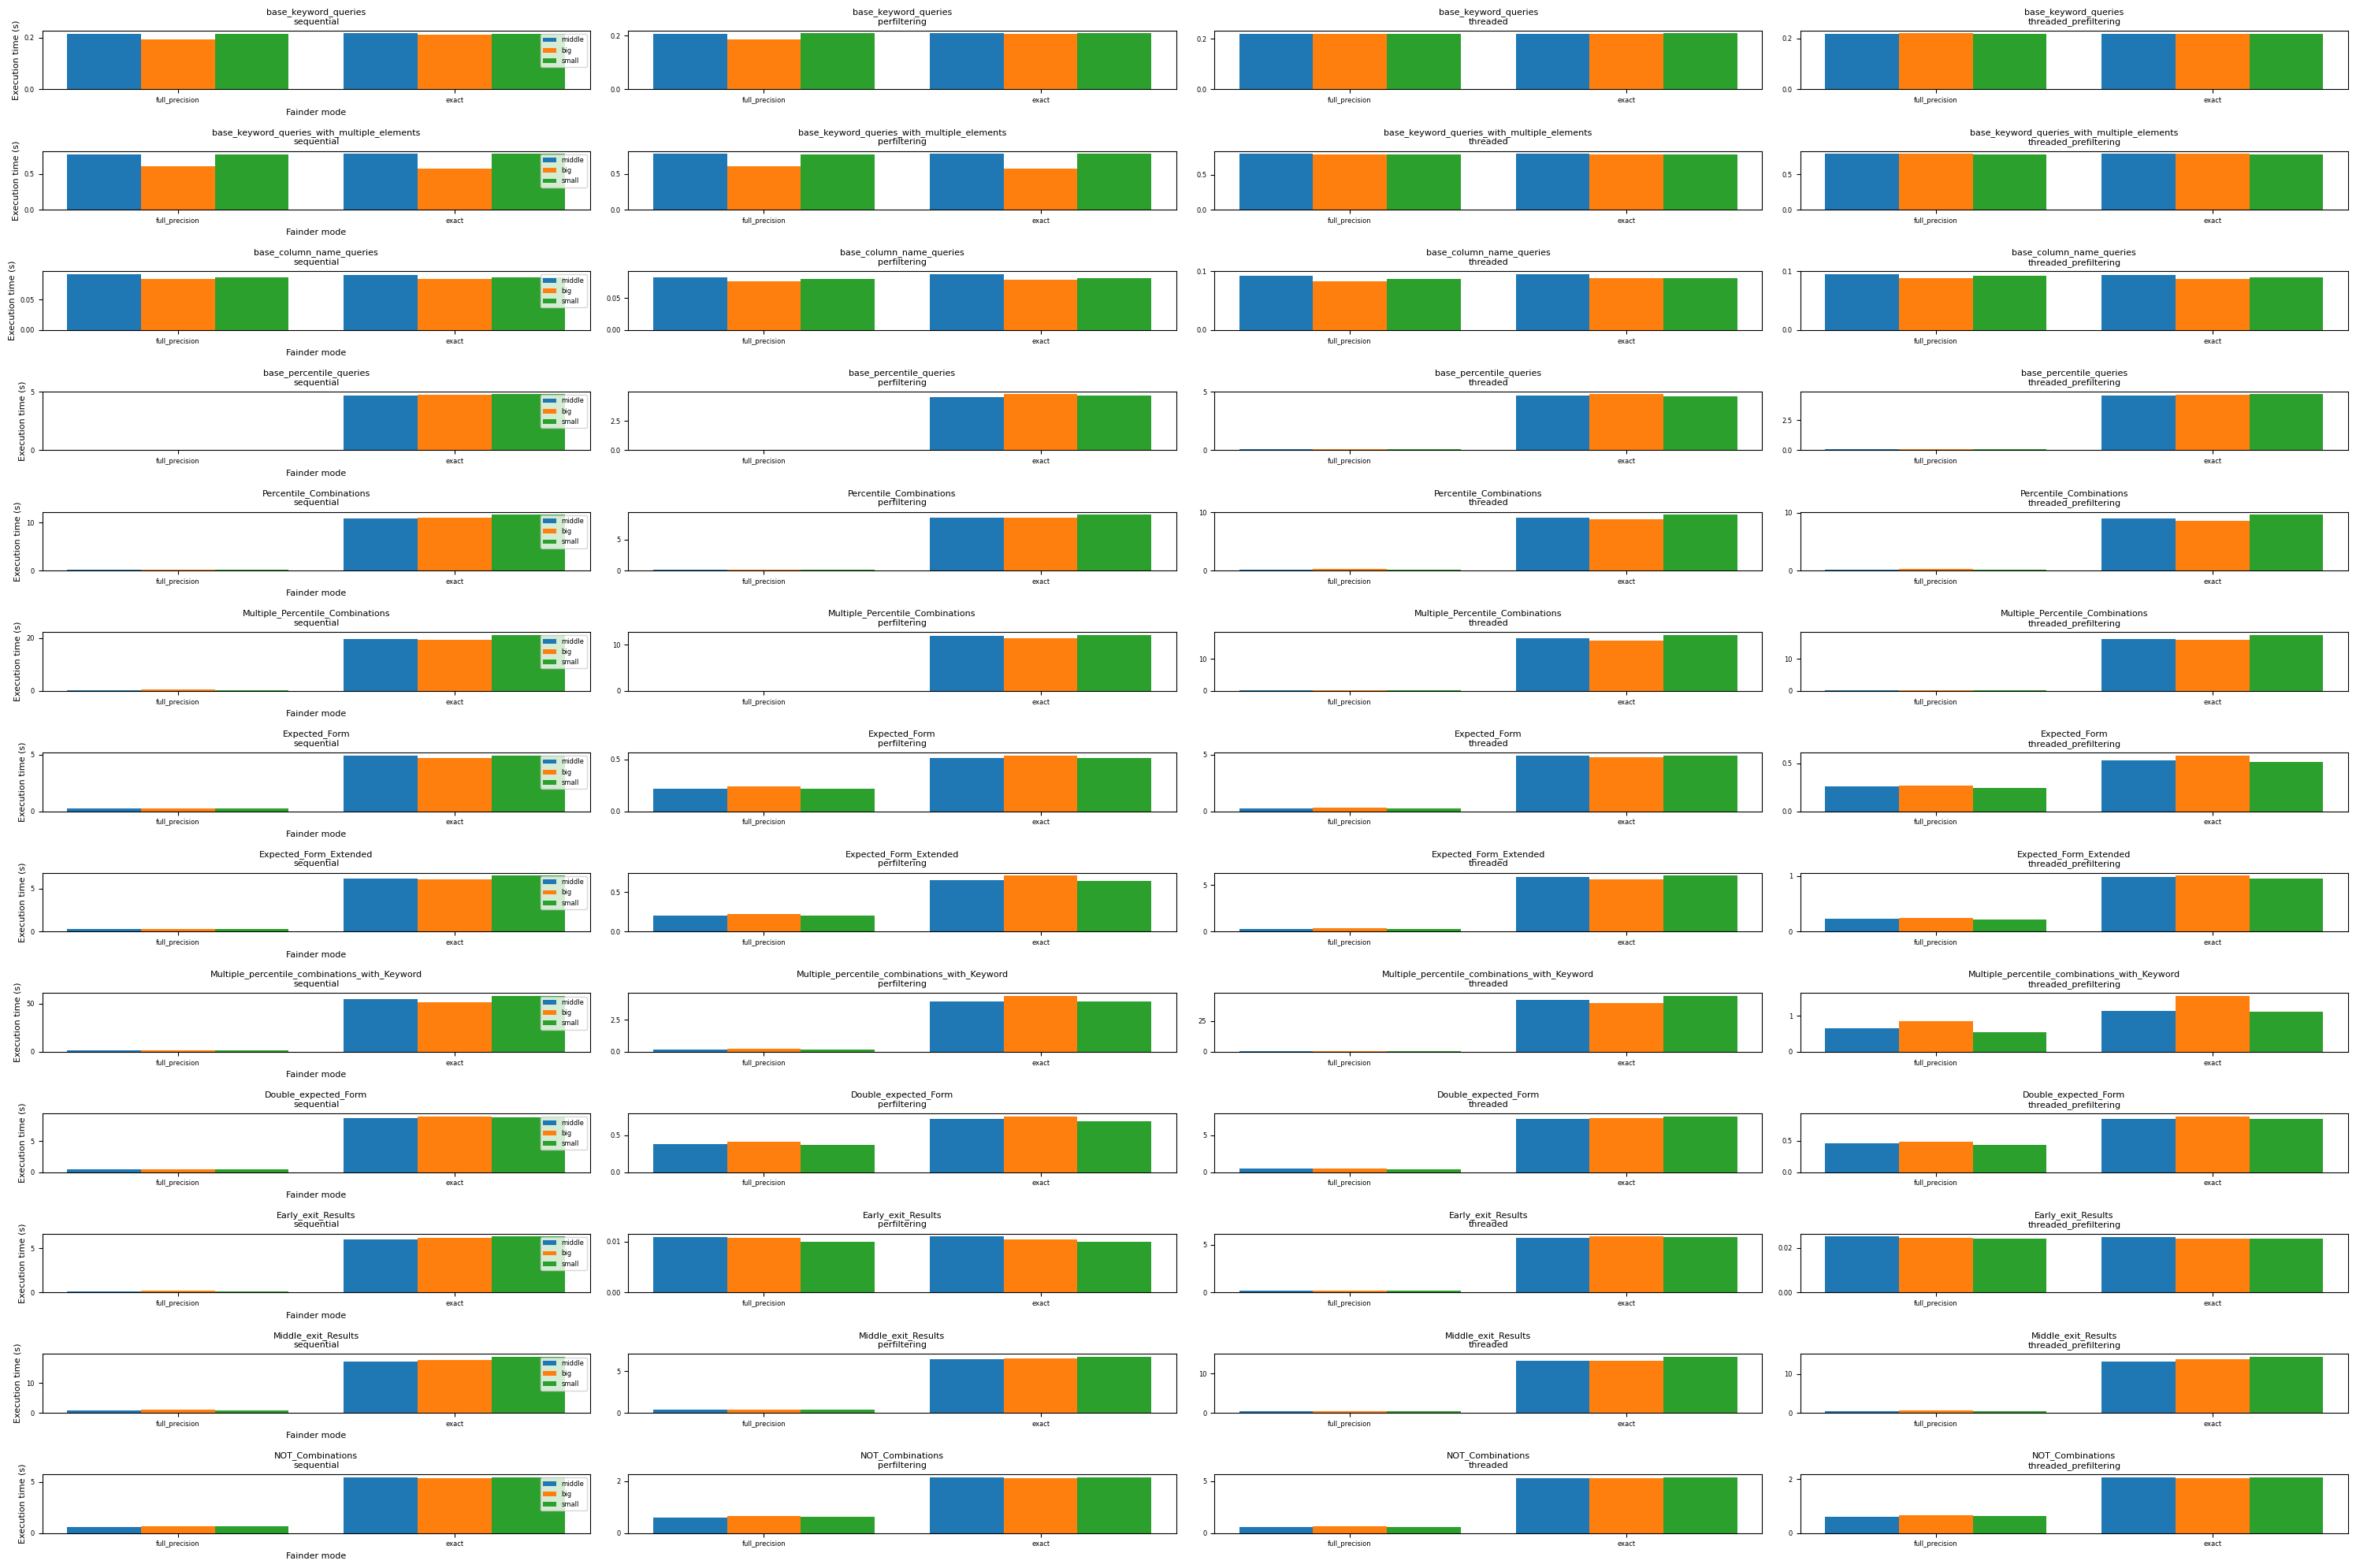

In [4]:
# Create combined figure without log scale
if commit_data:
    plt.figure(figsize=(30, 20))
    num_plots = len(categories) * len(scenarios)
    rows = (num_plots + 3) // 4
    cols = min(4, num_plots)

    for idx, (category, scenario) in enumerate(
        [(c, s) for c in categories for s in scenarios]
    ):
        plt.subplot(rows, cols, idx + 1)

        # Get data for each commit
        commit_means = {}
        for commit_name, df in commit_data:
            df_temp = df[(df["category"] == category) & (df["scenario"] == scenario)]
            mean_execution_times = df_temp.groupby("fainder_mode")[
                "execution_time"
            ].mean()
            commit_means[commit_name] = mean_execution_times

        if commit_means:
            x = np.arange(len(fainder_modes))
            width = 0.8 / len(commit_data)

            for i, (commit_name, means) in enumerate(commit_means.items()):
                values = [means.get(mode, 0) for mode in fainder_modes]
                plt.bar(x + i * width, values, width, label=commit_name)

            if idx % 4 == 0:
                plt.legend(loc="upper right", fontsize=6)
                plt.xlabel("Fainder mode", fontsize=8)
                plt.ylabel("Execution time (s)", fontsize=8)
            plt.xticks(
                x + width * (len(commit_data) - 1) / 2, fainder_modes, fontsize=6
            )
            plt.title(f"{category}\n{scenario}", fontsize=8)
            plt.yticks(fontsize=6)

    plt.tight_layout()
    plt.savefig("figures/regression/all_execution_times_without_log.png")

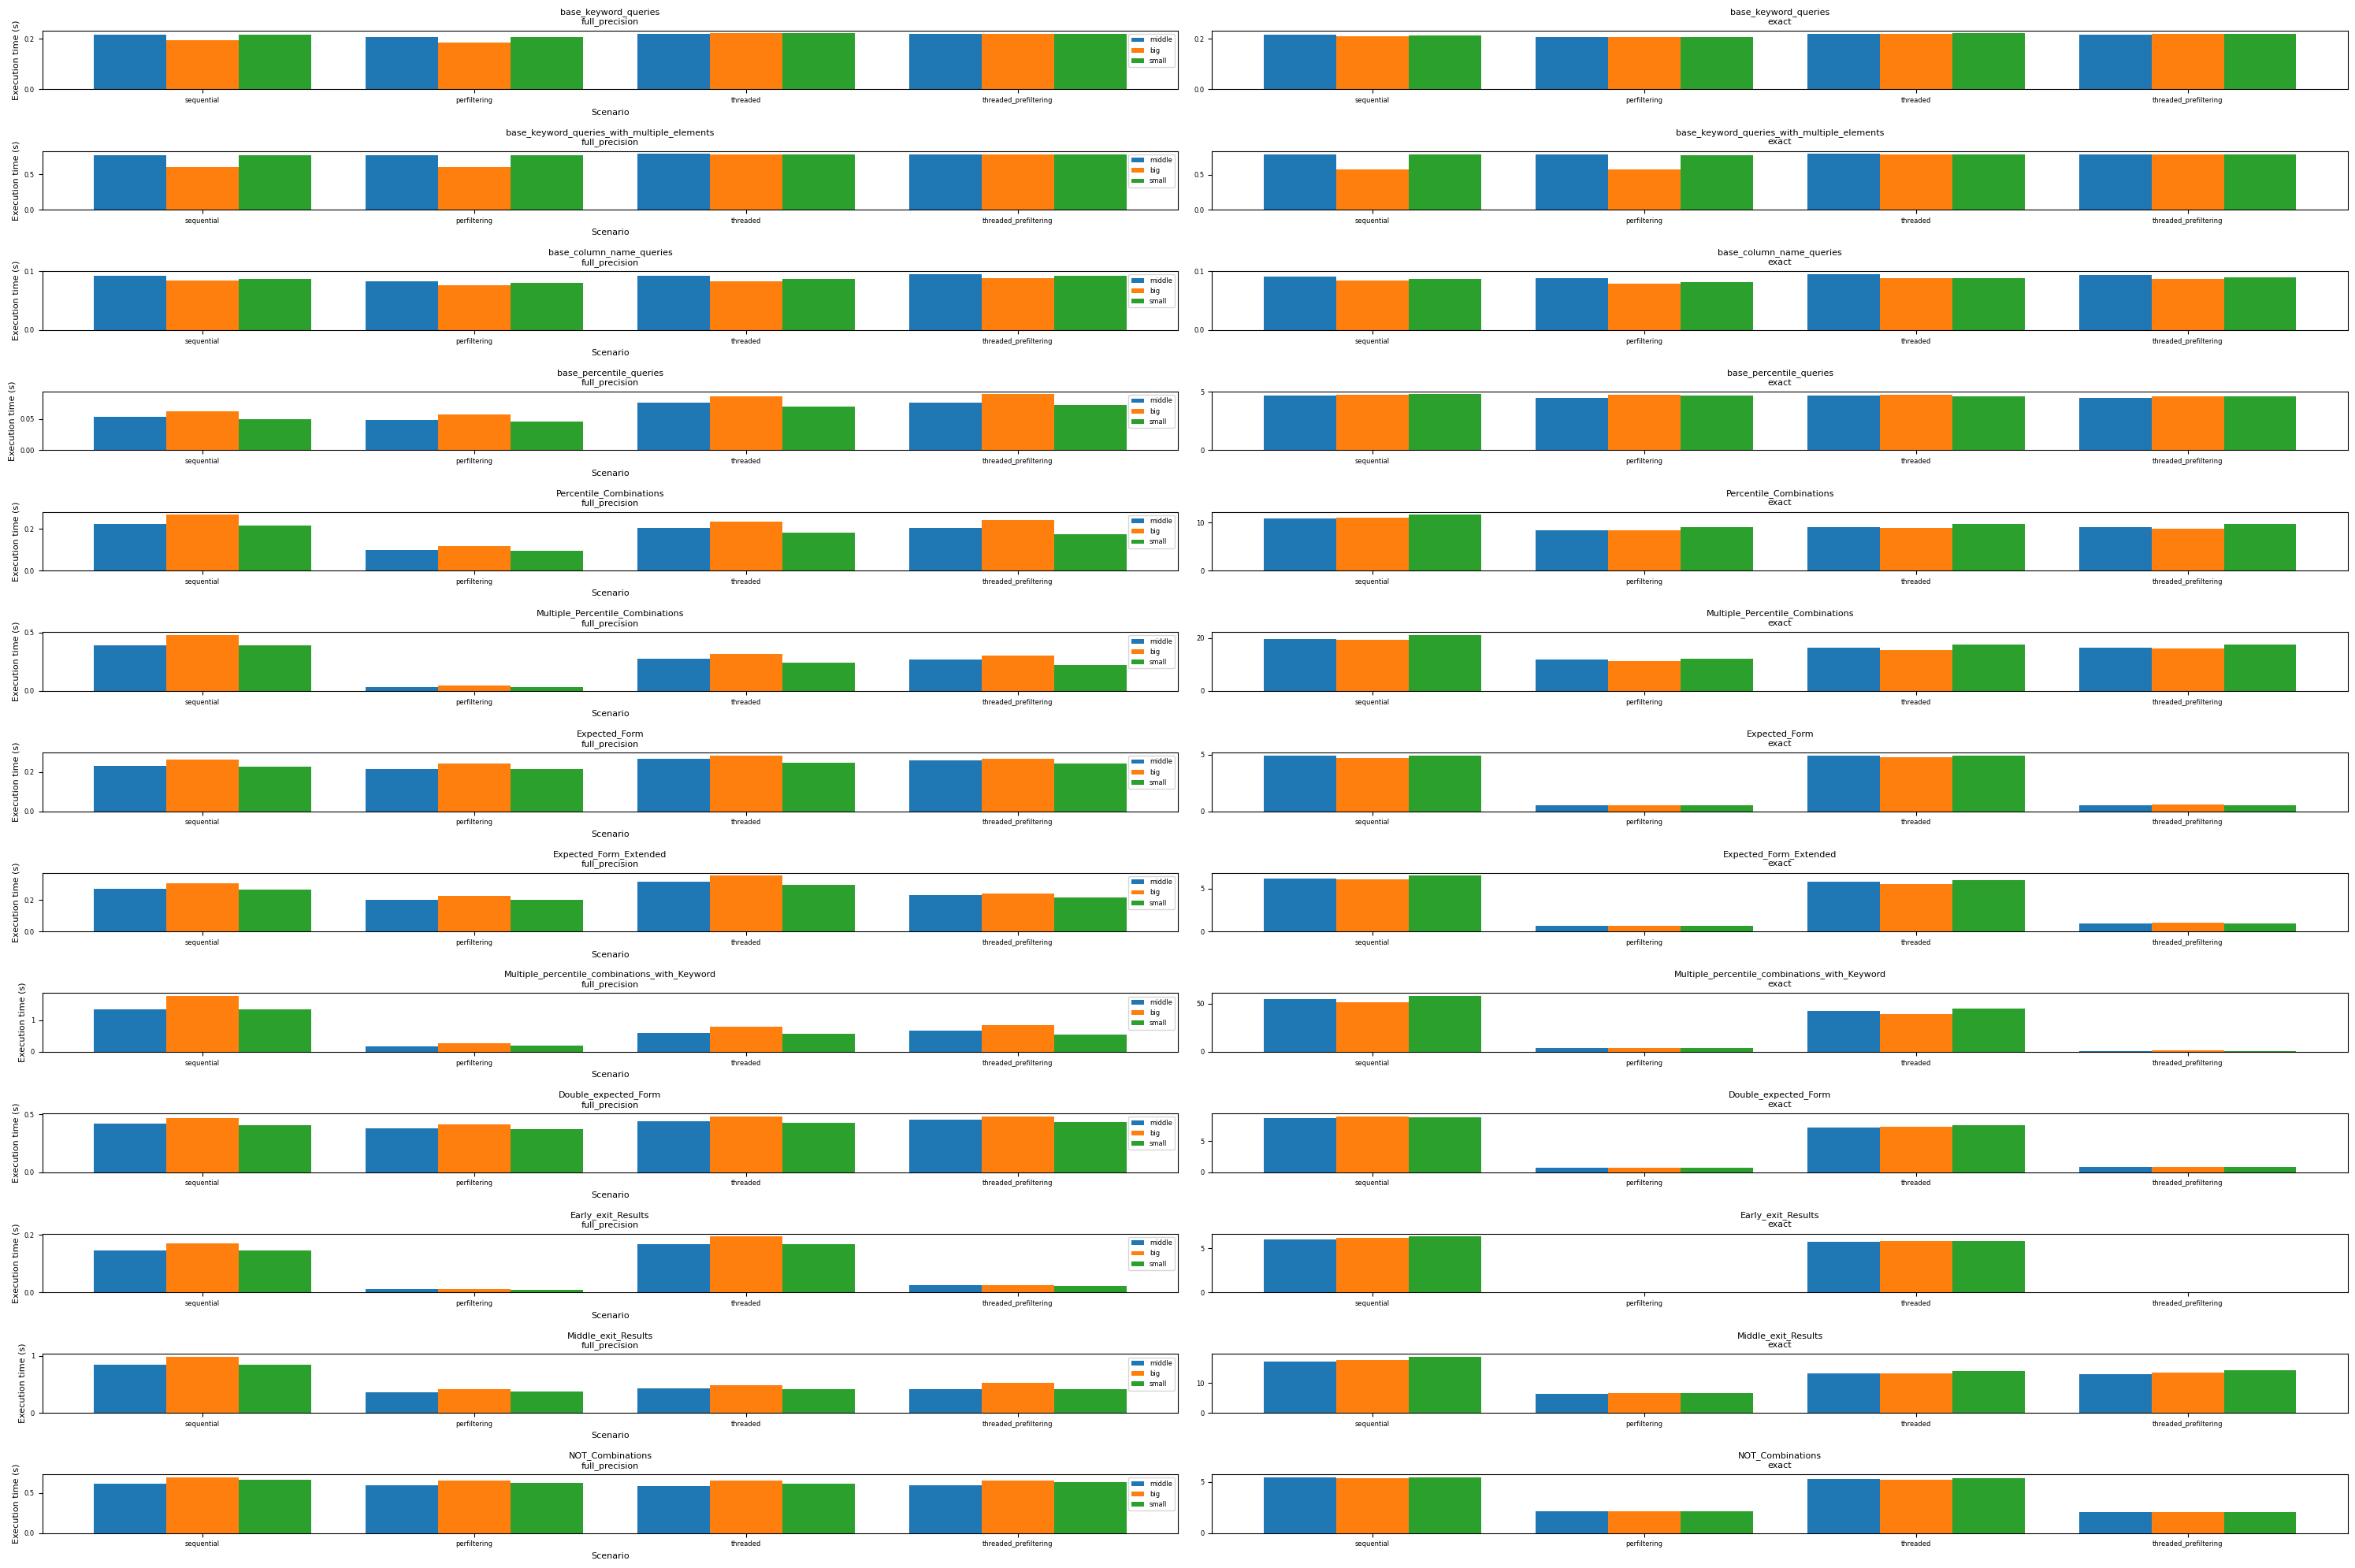

In [5]:
# Create combined figure by fainder mode without log scale
if commit_data:
    plt.figure(figsize=(30, 20))
    num_per_column = 2
    num_plots = len(categories) * len(fainder_modes)
    rows = (num_plots + num_per_column - 1) // num_per_column
    cols = min(num_per_column, num_plots)

    for idx, (category, fainder_mode) in enumerate(
        [(c, f) for c in categories for f in fainder_modes]
    ):
        plt.subplot(rows, cols, idx + 1)

        # Get data for each commit
        commit_means = {}
        for commit_name, df in commit_data:
            df_temp = df[
                (df["category"] == category) & (df["fainder_mode"] == fainder_mode)
            ]
            mean_execution_times = df_temp.groupby("scenario")["execution_time"].mean()
            commit_means[commit_name] = mean_execution_times

        if commit_means:
            x = np.arange(len(scenarios))
            width = 0.8 / len(commit_data)

            for i, (commit_name, means) in enumerate(commit_means.items()):
                values = [means.get(scenario, 0) for scenario in scenarios]
                plt.bar(x + i * width, values, width, label=commit_name)

            if idx % num_per_column == 0:
                plt.legend(loc="upper right", fontsize=6)
                plt.xlabel("Scenario", fontsize=8)
                plt.ylabel("Execution time (s)", fontsize=8)
            plt.xticks(x + width * (len(commit_data) - 1) / 2, scenarios, fontsize=6)
            plt.title(f"{category}\n{fainder_mode}", fontsize=8)
            plt.yticks(fontsize=6)

    plt.tight_layout()
    plt.savefig(
        "figures/regression/all_execution_times_without_log_by_fainder_mode.png"
    )

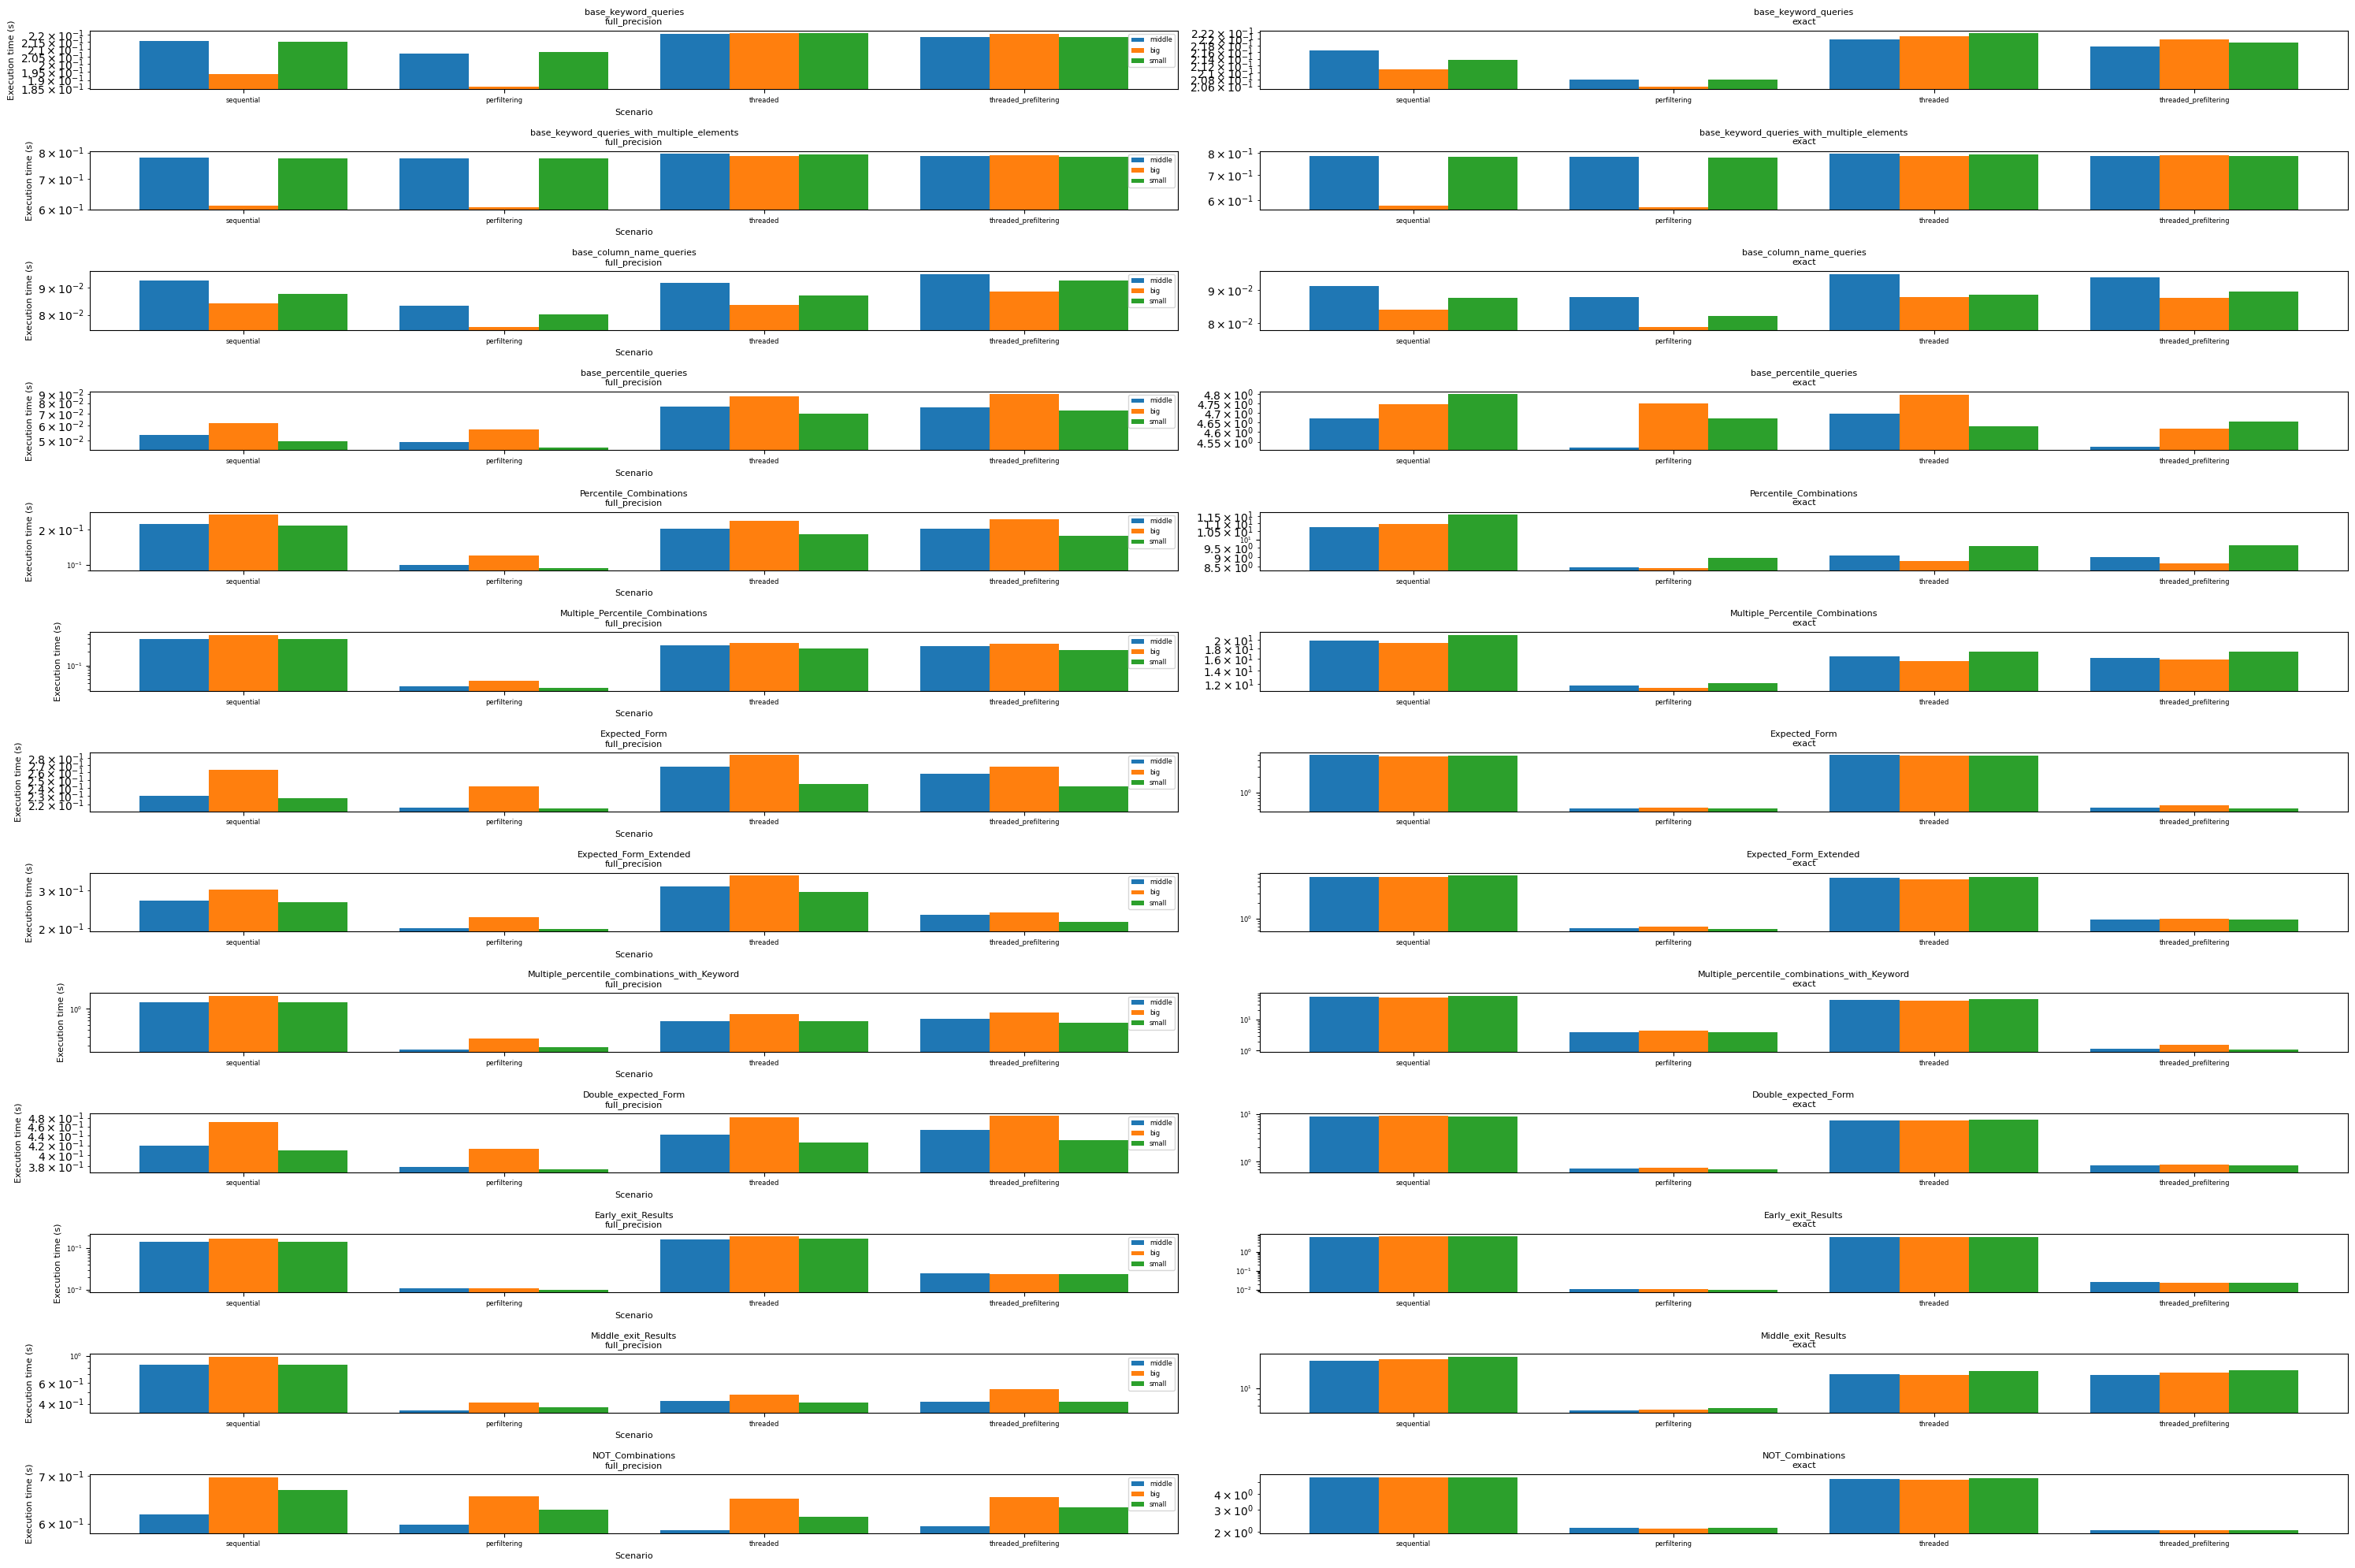

In [6]:
# Create combined figure by fainder mode with log scale
if commit_data:
    plt.figure(figsize=(30, 20))
    num_per_column = 2
    num_plots = len(categories) * len(fainder_modes)
    rows = (num_plots + num_per_column - 1) // num_per_column
    cols = min(num_per_column, num_plots)

    for idx, (category, fainder_mode) in enumerate(
        [(c, f) for c in categories for f in fainder_modes]
    ):
        plt.subplot(rows, cols, idx + 1)

        # Get data for each commit
        commit_means = {}
        for commit_name, df in commit_data:
            df_temp = df[
                (df["category"] == category) & (df["fainder_mode"] == fainder_mode)
            ]
            mean_execution_times = df_temp.groupby("scenario")["execution_time"].mean()
            commit_means[commit_name] = mean_execution_times

        if commit_means:
            x = np.arange(len(scenarios))
            width = 0.8 / len(commit_data)

            for i, (commit_name, means) in enumerate(commit_means.items()):
                values = [means.get(scenario, 0) for scenario in scenarios]
                plt.bar(x + i * width, values, width, label=commit_name)

            plt.yscale("log")

            if idx % num_per_column == 0:
                plt.legend(loc="upper right", fontsize=6)
                plt.xlabel("Scenario", fontsize=8)
                plt.ylabel("Execution time (s)", fontsize=8)
            plt.xticks(x + width * (len(commit_data) - 1) / 2, scenarios, fontsize=6)
            plt.title(f"{category}\n{fainder_mode}", fontsize=8)
            plt.yticks(fontsize=6)

    plt.tight_layout()
    plt.savefig("figures/regression/all_execution_times_by_fainder_mode.png")

/tmp/ipykernel_39757/3209032185.py:28: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")
/tmp/ipykernel_39757/3209032185.py:28: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")
/tmp/ipykernel_39757/3209032185.py:28: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")
/tmp/ipykernel_39757/3209032185.py:28: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")
/tmp/ipykernel_39757/3209032185.py:28: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")
/tmp/ipykernel_39757/3209032185.py:28: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")
/tmp/ipykernel_39757/3209032185.py:28: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")
/tmp/ipykernel_39757/3209032185.py:28: Us

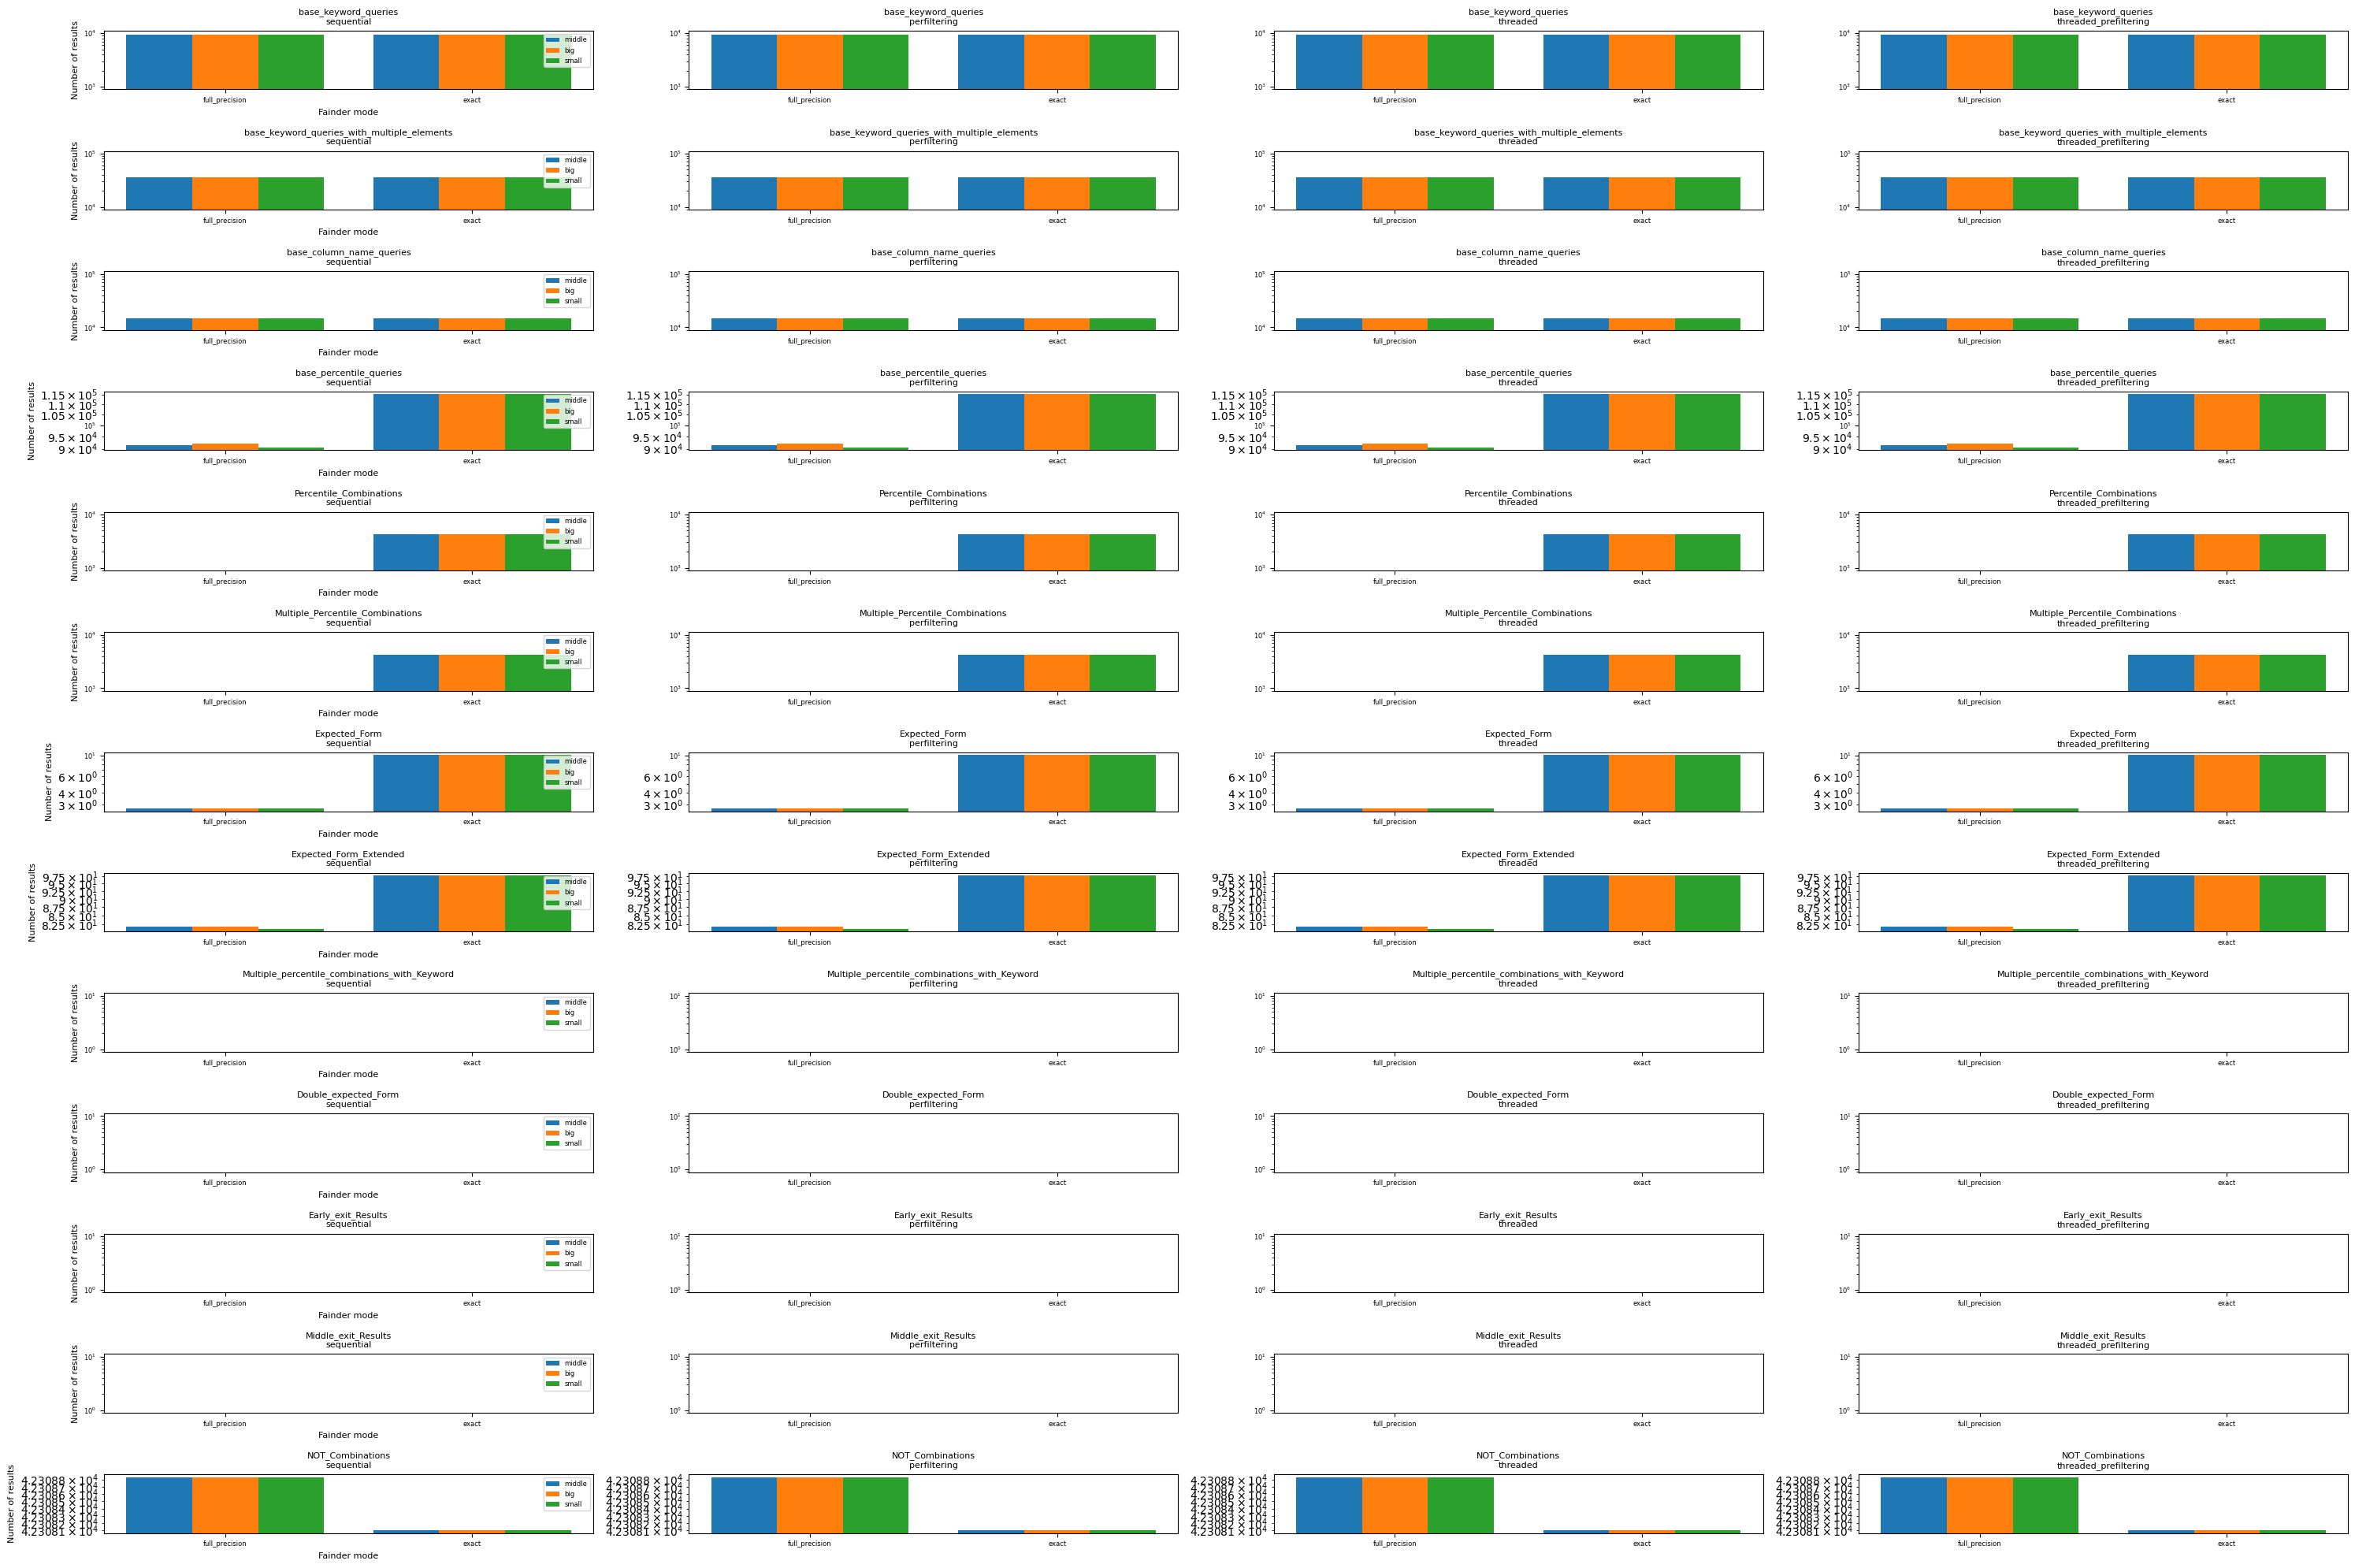

In [7]:
# Create combined figure for number of results with log scale
if commit_data:
    plt.figure(figsize=(30, 20))
    num_plots = len(categories) * len(scenarios)
    rows = (num_plots + 3) // 4
    cols = min(4, num_plots)

    for idx, (category, scenario) in enumerate(
        [(c, s) for c in categories for s in scenarios]
    ):
        plt.subplot(rows, cols, idx + 1)

        # Get data for each commit
        commit_means = {}
        for commit_name, df in commit_data:
            df_temp = df[(df["category"] == category) & (df["scenario"] == scenario)]
            mean_num_results = df_temp.groupby("fainder_mode")["num_results"].mean()
            commit_means[commit_name] = mean_num_results

        if commit_means:
            x = np.arange(len(fainder_modes))
            width = 0.8 / len(commit_data)

            for i, (commit_name, means) in enumerate(commit_means.items()):
                values = [means.get(mode, 0) for mode in fainder_modes]
                plt.bar(x + i * width, values, width, label=commit_name)

            plt.yscale("log")

            if idx % 4 == 0:
                plt.legend(loc="upper right", fontsize=6)
                plt.xlabel("Fainder mode", fontsize=8)
                plt.ylabel("Number of results", fontsize=8)
            plt.xticks(
                x + width * (len(commit_data) - 1) / 2, fainder_modes, fontsize=6
            )
            plt.title(f"{category}\n{scenario}", fontsize=8)
            plt.yticks(fontsize=6)

    plt.tight_layout()
    plt.savefig("figures/regression/all_num_results.png")

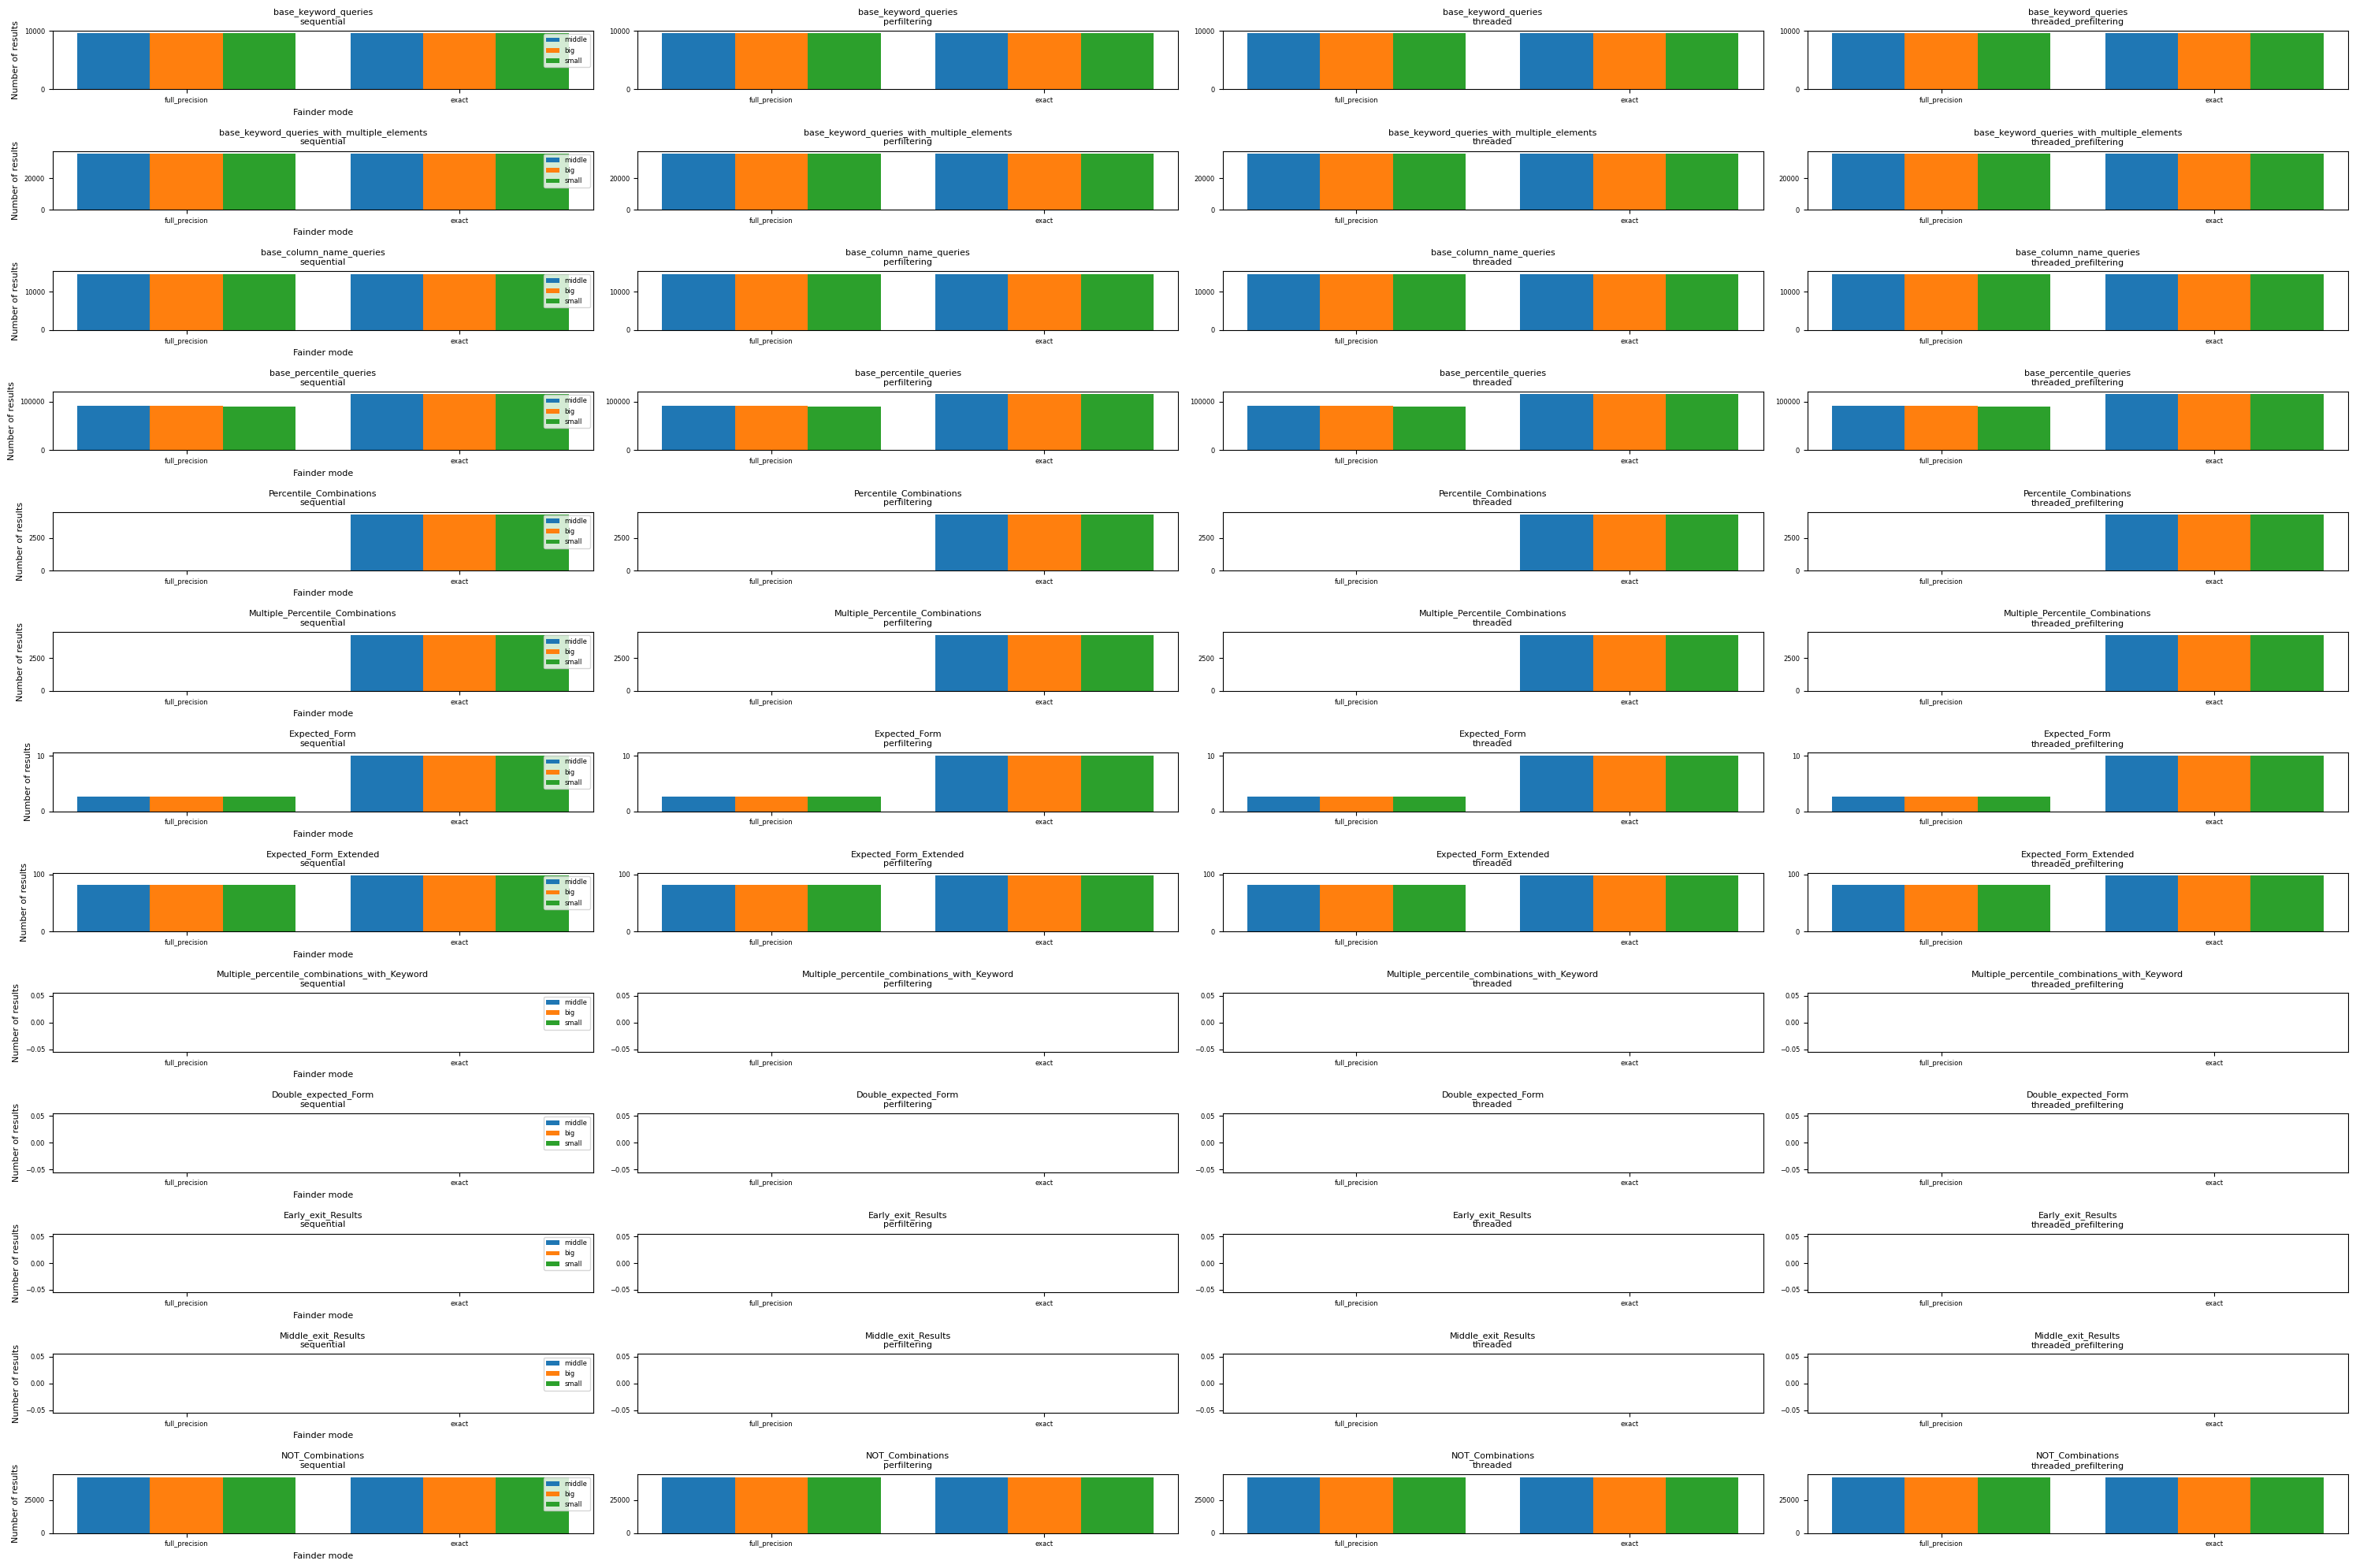

In [8]:
# Create combined figure for number of results without log scale
if commit_data:
    plt.figure(figsize=(30, 20))
    num_plots = len(categories) * len(scenarios)
    rows = (num_plots + 3) // 4
    cols = min(4, num_plots)

    for idx, (category, scenario) in enumerate(
        [(c, s) for c in categories for s in scenarios]
    ):
        plt.subplot(rows, cols, idx + 1)

        # Get data for each commit
        commit_means = {}
        for commit_name, df in commit_data:
            df_temp = df[(df["category"] == category) & (df["scenario"] == scenario)]
            mean_num_results = df_temp.groupby("fainder_mode")["num_results"].mean()
            commit_means[commit_name] = mean_num_results

        if commit_means:
            x = np.arange(len(fainder_modes))
            width = 0.8 / len(commit_data)

            for i, (commit_name, means) in enumerate(commit_means.items()):
                values = [means.get(mode, 0) for mode in fainder_modes]
                plt.bar(x + i * width, values, width, label=commit_name)

            if idx % 4 == 0:
                plt.legend(loc="upper right", fontsize=6)
                plt.xlabel("Fainder mode", fontsize=8)
                plt.ylabel("Number of results", fontsize=8)
            plt.xticks(
                x + width * (len(commit_data) - 1) / 2, fainder_modes, fontsize=6
            )
            plt.title(f"{category}\n{scenario}", fontsize=8)
            plt.yticks(fontsize=6)

    plt.tight_layout()
    plt.savefig("figures/regression/all_num_results_without_log.png")

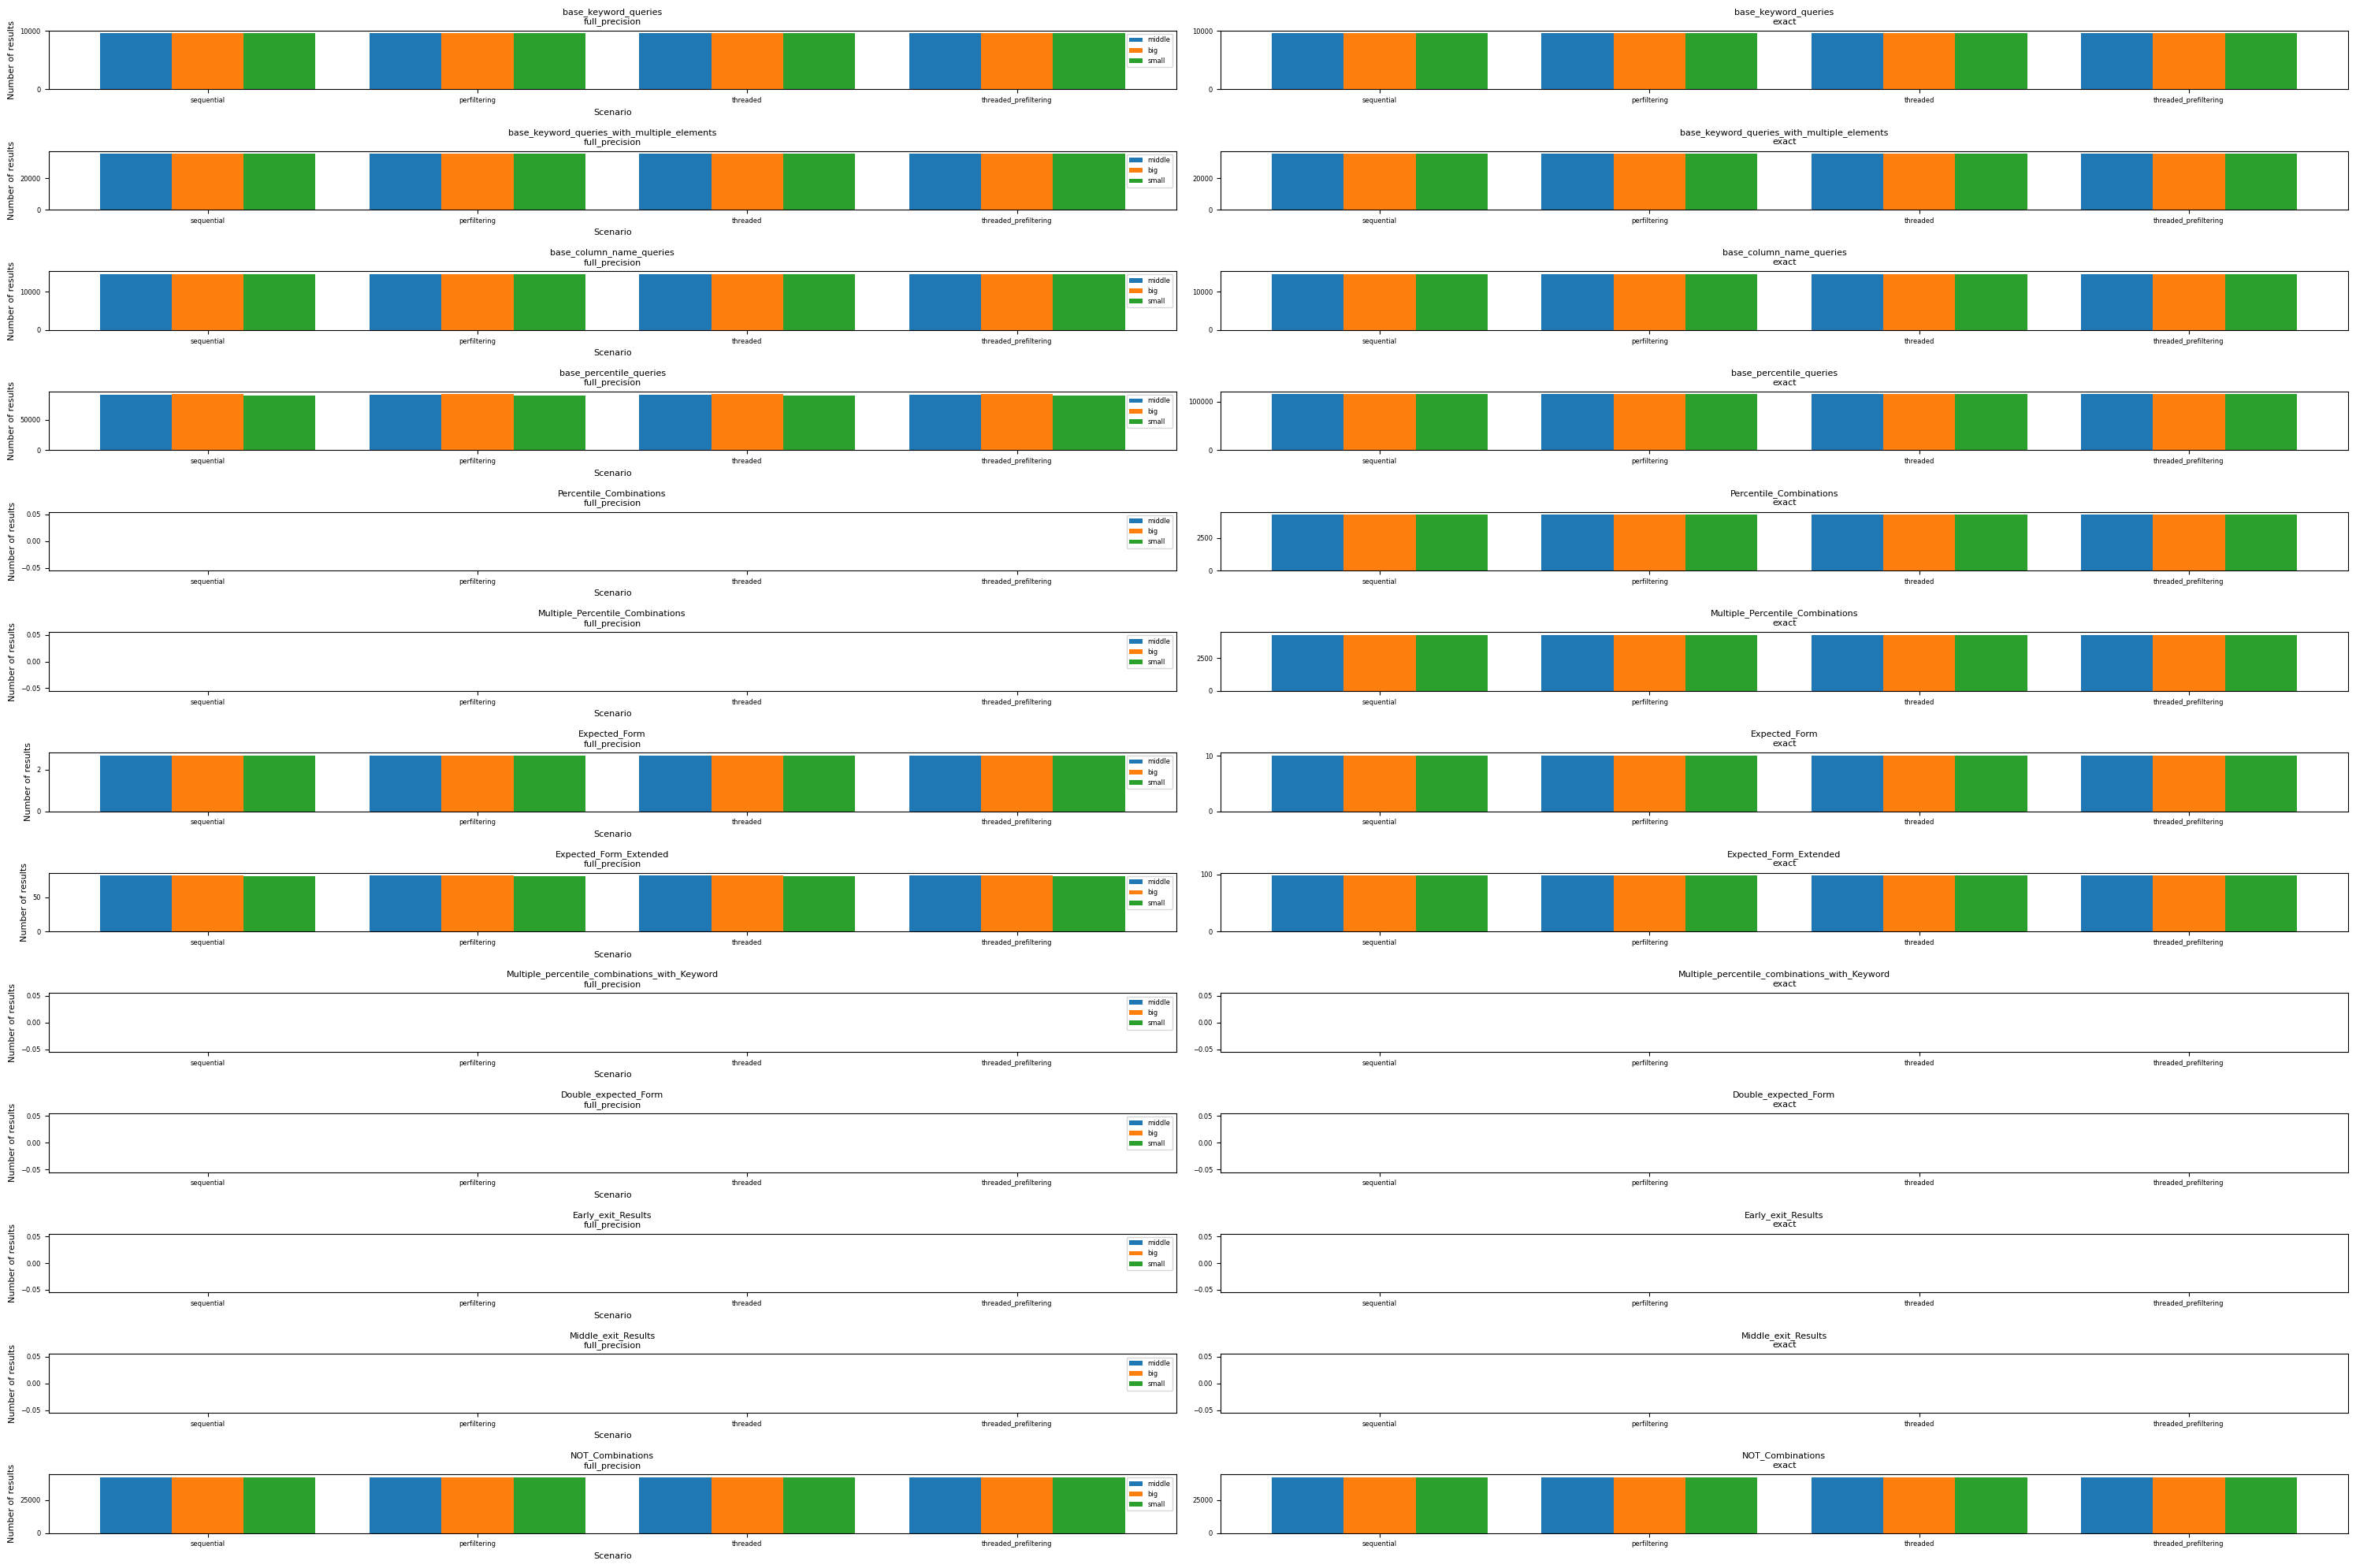

In [9]:
# Create combined figure by fainder mode without log scale
if commit_data:
    plt.figure(figsize=(30, 20))
    num_per_column = 2
    num_plots = len(categories) * len(fainder_modes)
    rows = (num_plots + num_per_column - 1) // num_per_column
    cols = min(num_per_column, num_plots)

    for idx, (category, fainder_mode) in enumerate(
        [(c, f) for c in categories for f in fainder_modes]
    ):
        plt.subplot(rows, cols, idx + 1)

        # Get data for each commit
        commit_means = {}
        for commit_name, df in commit_data:
            df_temp = df[
                (df["category"] == category) & (df["fainder_mode"] == fainder_mode)
            ]
            mean_num_results = df_temp.groupby("scenario")["num_results"].mean()
            commit_means[commit_name] = mean_num_results

        if commit_means:
            x = np.arange(len(scenarios))
            width = 0.8 / len(commit_data)

            for i, (commit_name, means) in enumerate(commit_means.items()):
                values = [means.get(scenario, 0) for scenario in scenarios]
                plt.bar(x + i * width, values, width, label=commit_name)

            if idx % num_per_column == 0:
                plt.legend(loc="upper right", fontsize=6)
                plt.xlabel("Scenario", fontsize=8)
                plt.ylabel("Number of results", fontsize=8)
            plt.xticks(x + width * (len(commit_data) - 1) / 2, scenarios, fontsize=6)
            plt.title(f"{category}\n{fainder_mode}", fontsize=8)
            plt.yticks(fontsize=6)

    plt.tight_layout()
    plt.savefig("figures/regression/all_num_results_without_log_by_fainder_mode.png")

/tmp/ipykernel_39757/1458947475.py:31: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")
/tmp/ipykernel_39757/1458947475.py:31: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")
/tmp/ipykernel_39757/1458947475.py:31: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")
/tmp/ipykernel_39757/1458947475.py:31: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")
/tmp/ipykernel_39757/1458947475.py:31: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")
/tmp/ipykernel_39757/1458947475.py:31: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")
/tmp/ipykernel_39757/1458947475.py:31: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")
/tmp/ipykernel_39757/1458947475.py:31: Us

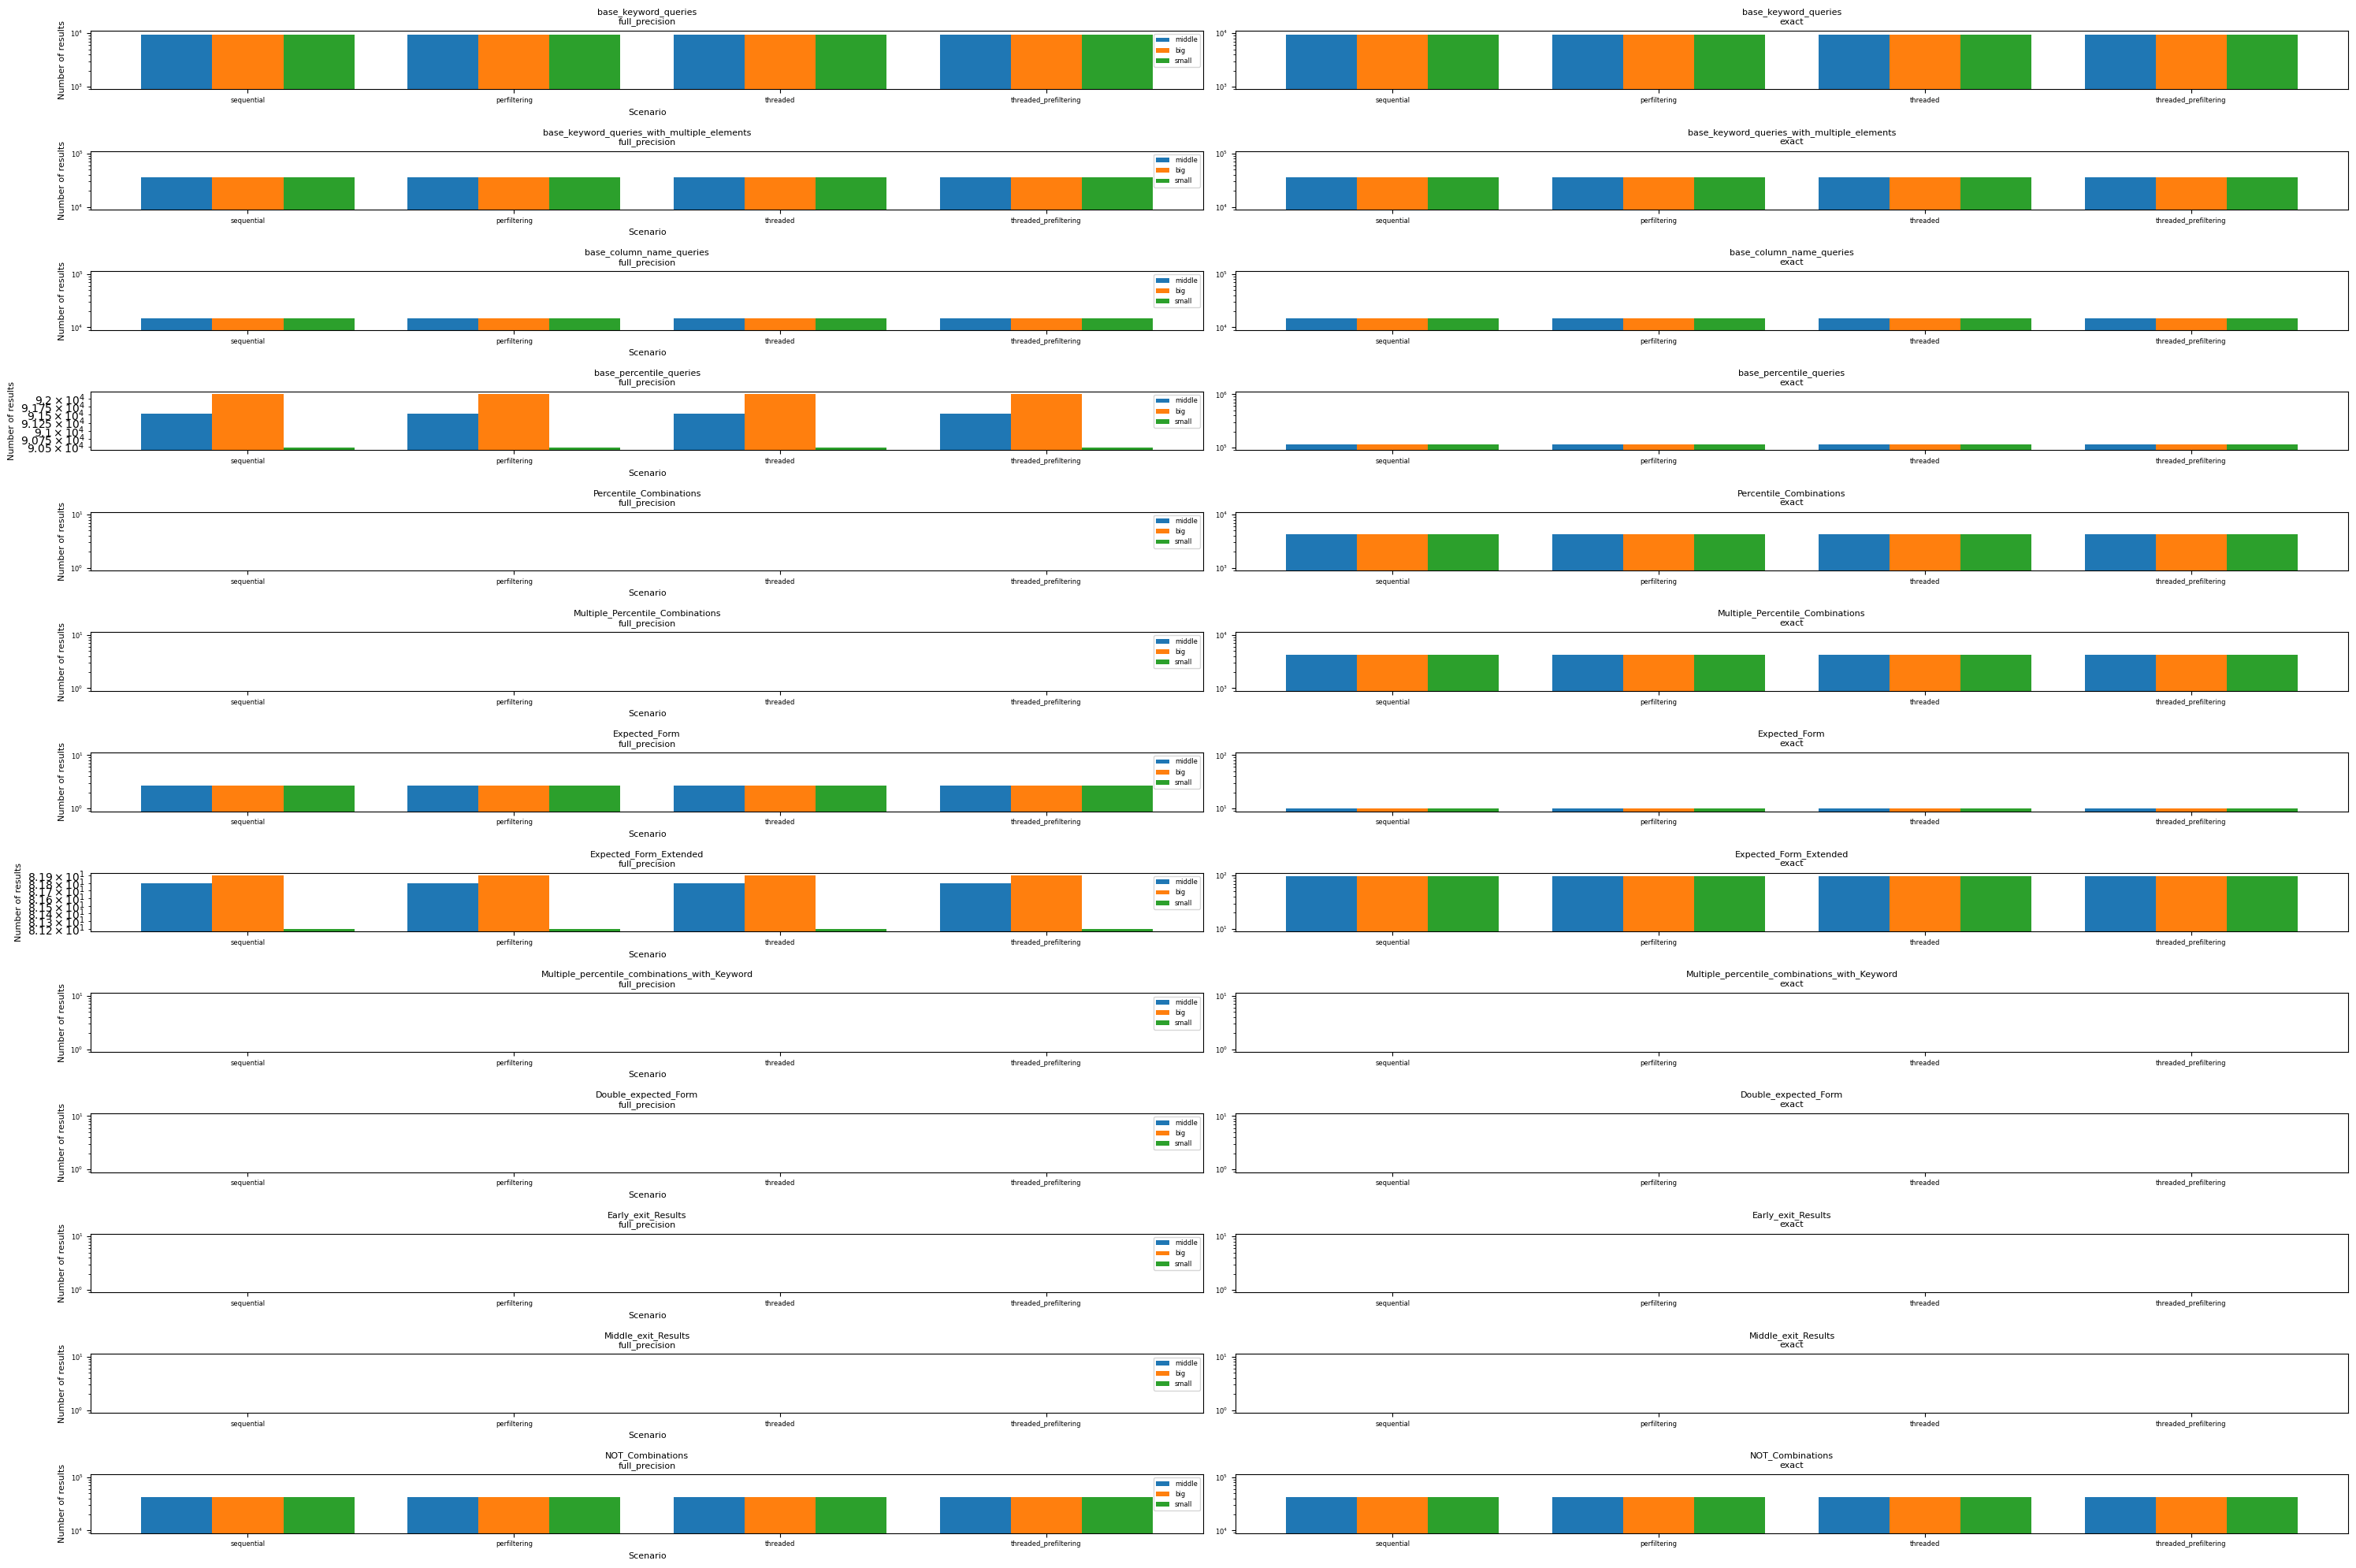

In [10]:
# Create combined figure by fainder mode with log scale
if commit_data:
    plt.figure(figsize=(30, 20))
    num_per_column = 2
    num_plots = len(categories) * len(fainder_modes)
    rows = (num_plots + num_per_column - 1) // num_per_column
    cols = min(num_per_column, num_plots)

    for idx, (category, fainder_mode) in enumerate(
        [(c, f) for c in categories for f in fainder_modes]
    ):
        plt.subplot(rows, cols, idx + 1)

        # Get data for each commit
        commit_means = {}
        for commit_name, df in commit_data:
            df_temp = df[
                (df["category"] == category) & (df["fainder_mode"] == fainder_mode)
            ]
            mean_num_results = df_temp.groupby("scenario")["num_results"].mean()
            commit_means[commit_name] = mean_num_results

        if commit_means:
            x = np.arange(len(scenarios))
            width = 0.8 / len(commit_data)

            for i, (commit_name, means) in enumerate(commit_means.items()):
                values = [means.get(scenario, 0) for scenario in scenarios]
                plt.bar(x + i * width, values, width, label=commit_name)

            plt.yscale("log")

            if idx % num_per_column == 0:
                plt.legend(loc="upper right", fontsize=6)
                plt.xlabel("Scenario", fontsize=8)
                plt.ylabel("Number of results", fontsize=8)
            plt.xticks(x + width * (len(commit_data) - 1) / 2, scenarios, fontsize=6)
            plt.title(f"{category}\n{fainder_mode}", fontsize=8)
            plt.yticks(fontsize=6)

    plt.tight_layout()
    plt.savefig("figures/regression/all_num_results_by_fainder_mode.png")

In [11]:
# For each category and scenario create line plots with queries on x-axis and execution time on y-axis
if commit_data:
    for category in categories:
        for scenario in scenarios:
            plt.figure(figsize=(12, 8))

            for commit_name, df in commit_data:
                df_temp = df[
                    (df["category"] == category) & (df["scenario"] == scenario)
                ]

                for fainder_mode in df_temp["fainder_mode"].unique():
                    df_fainder_mode = df_temp[
                        df_temp["fainder_mode"] == fainder_mode
                    ].reset_index(drop=True)

                    plt.plot(
                        df_fainder_mode.index,
                        df_fainder_mode["execution_time"],
                        label=f"{commit_name} {fainder_mode}",
                        marker="o",
                    )

            plt.title(f"Execution time for {category} in {scenario}")
            plt.xlabel("Query")
            plt.ylabel("Execution time (s)")
            plt.legend()

            # Save individual figure
            plt.savefig(
                f"figures/regression/execution_time_{category}_{scenario}_query.png",
                bbox_inches="tight",
            )
            plt.close()

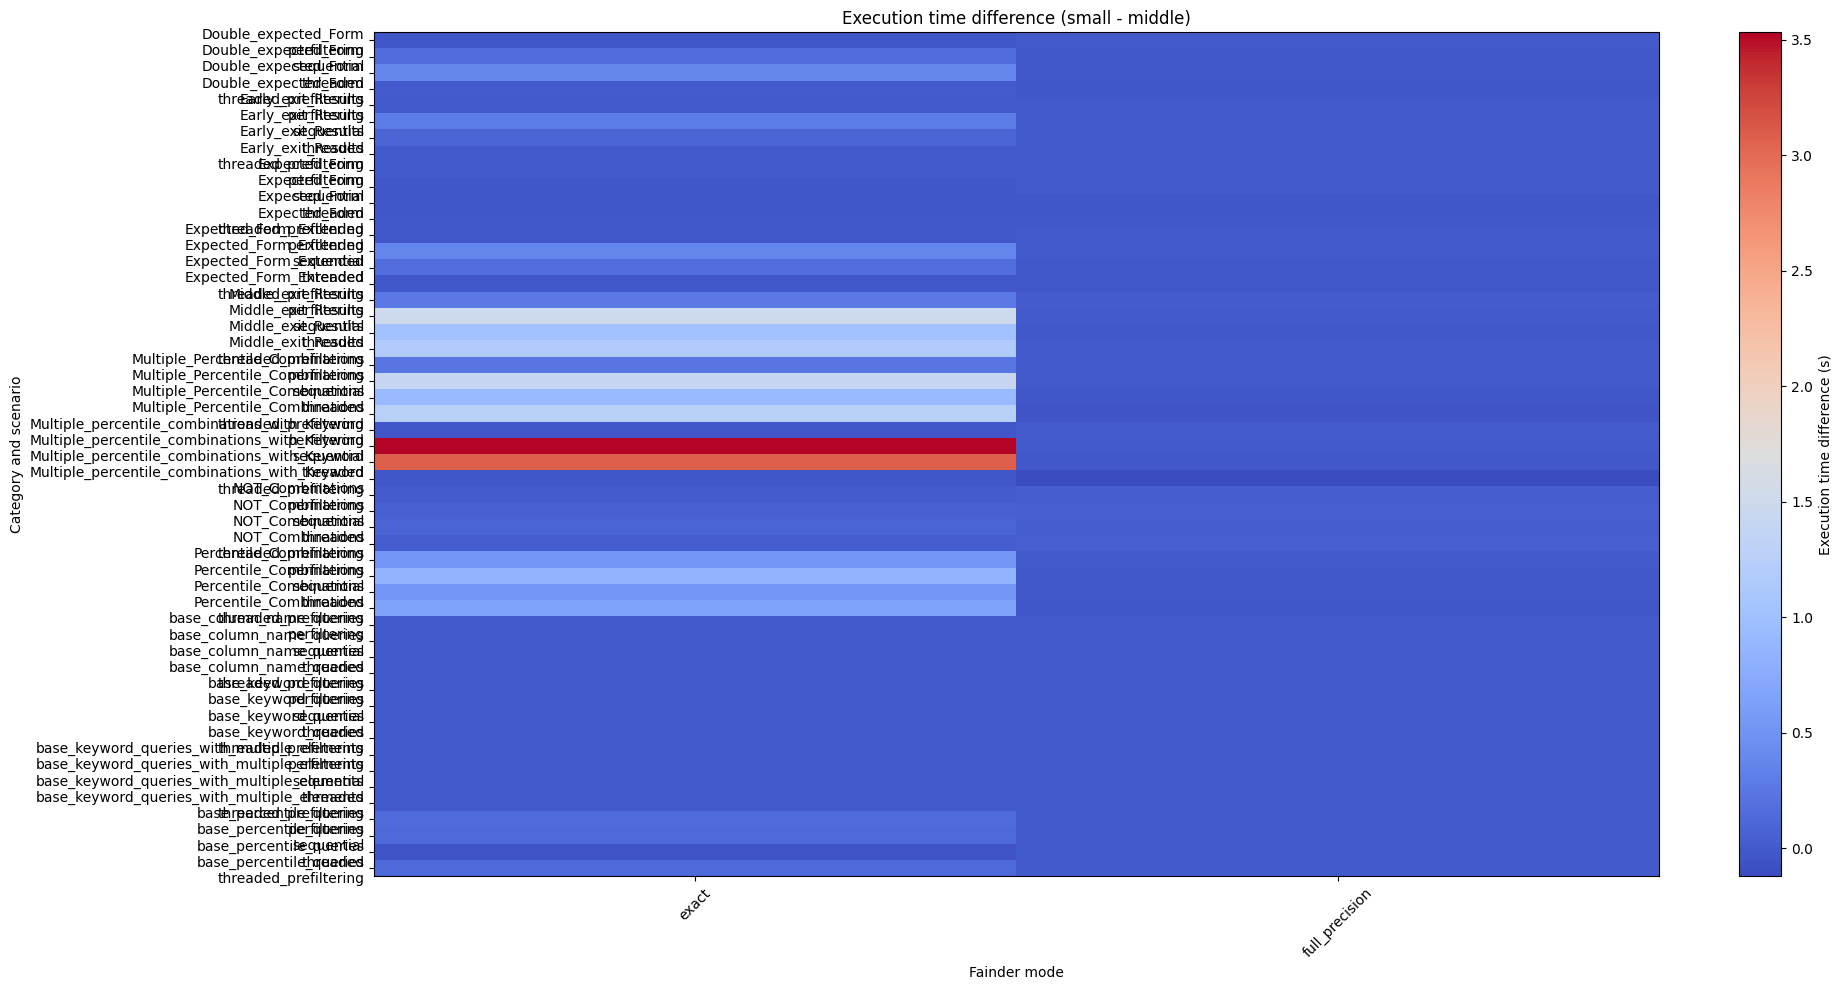

In [12]:
# Create heatmap showing execution time differences between first and last commits
if len(commit_data) >= 2:
    plt.figure(figsize=(20, 10))

    # Use first commit as baseline and last commit for comparison
    baseline_name, baseline_df = commit_data[0]
    comparison_name, comparison_df = commit_data[-1]

    # Group by category, scenario, and fainder mode
    baseline_grouped = (
        baseline_df.groupby(["category", "scenario", "fainder_mode"])["execution_time"]
        .mean()
        .reset_index()
    )
    comparison_grouped = (
        comparison_df.groupby(["category", "scenario", "fainder_mode"])[
            "execution_time"
        ]
        .mean()
        .reset_index()
    )

    # Filter to common combinations
    baseline_grouped = baseline_grouped[
        baseline_grouped["fainder_mode"].isin(
            comparison_grouped["fainder_mode"].unique()
        )
    ]
    comparison_grouped = comparison_grouped[
        comparison_grouped["fainder_mode"].isin(
            baseline_grouped["fainder_mode"].unique()
        )
    ]

    # Create a pivot table for the heatmap
    heatmap_data = pd.merge(
        comparison_grouped,
        baseline_grouped,
        on=["category", "scenario", "fainder_mode"],
        suffixes=(f"_{comparison_name}", f"_{baseline_name}"),
    )
    heatmap_data["execution_time_diff"] = (
        heatmap_data[f"execution_time_{comparison_name}"]
        - heatmap_data[f"execution_time_{baseline_name}"]
    )
    heatmap_data_pivot = heatmap_data.pivot(
        index=["category", "scenario"],
        columns="fainder_mode",
        values="execution_time_diff",
    )

    # Create a heatmap
    plt.imshow(
        heatmap_data_pivot,
        cmap="coolwarm",
        aspect="auto",
        interpolation="nearest",
    )
    plt.colorbar(label="Execution time difference (s)")
    plt.title(f"Execution time difference ({comparison_name} - {baseline_name})")
    plt.xlabel("Fainder mode")
    plt.ylabel("Category and scenario")
    plt.xticks(
        range(len(heatmap_data_pivot.columns)),
        list(heatmap_data_pivot.columns),
        rotation=45,
    )
    plt.yticks(
        range(len(heatmap_data_pivot.index)),
        [f"{cat}\n{scen}" for cat, scen in heatmap_data_pivot.index],
    )
    plt.tight_layout()
    plt.savefig(
        "figures/regression/execution_time_diff_heatmap.png", bbox_inches="tight"
    )
    plt.show()